In [ ]:
# Setup
import json
from pathlib import Path
import sys
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from tqdm.auto import tqdm

sys.path.append("../")

# Import standard features for geographical analysis
from src.constants.features import STANDARD_FEATURES
from src.utils.logger import setup_logger

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"figure.figsize": (14, 8), "font.size": 11})

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
folder_depth = "../"
log = setup_logger("chapter_two", log_file=f"{folder_depth}/logs/chapter_two.log")
DATA_DIR = Path("data")
RES_DIR = Path("../res/chapter_two")
FIGURES_DIR = RES_DIR / "figures"
TABLES_DIR = RES_DIR / "tables"
DATA_OUT_DIR = RES_DIR / "data"

for d in [FIGURES_DIR, TABLES_DIR, DATA_OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)
# Paths & Config
PREDICTIONS_PATH = Path("../data/predictions")
CHAPTER_ONE_PATH = Path("../res/chapter_one")
RESULTS_PATH = Path("../res/chapter_two")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

TRAIN_START, TRAIN_END = "2009-01-01", "2018-12-31"
TEST_START, TEST_END = "2019-01-01", "2020-12-31"

# Clipping bounds for visualization (raw values preserved for stats)
NSE_CLIP = (-2.0, 1.0)
DELTA_CLIP = (-1.5, 1.0)

MODELS = ["lstm", "rfr", "hbv", "gr4j"]
COLORS = {"lstm": "#2E86AB", "rfr": "#A23B72", "hbv": "#F18F01", "gr4j": "#C73E1D"}

print("Setup complete!")


Setup complete!


# Generalization Gap Analysis: Fine-Tune Gauges

Investigating **why** fine-tune gauges (n=265) show performance degradation between Train (2009-2018) and Test (2019-2020).

**Visualization Note**: NSE values clipped to `[-2, 1]` for plots; statistics use raw values.


In [ ]:
# Load all data
fine_tune_gauges = gpd.read_file("../res/FineTuneGauges.gpkg")
fine_tune_gauges.set_index("gauge_id", inplace=True)
fine_tune_gauges.index = fine_tune_gauges.index.astype(str)
ft_index = fine_tune_gauges.index.tolist()

hydro_clusters = gpd.read_file(CHAPTER_ONE_PATH / "tables" / "hydro_clustered_gauges.geojson")
hydro_clusters.set_index("gauge_id", inplace=True)
hydro_clusters.index = hydro_clusters.index.astype(str)

with open(CHAPTER_ONE_PATH / "hydro_cluster_descriptions.json") as f:
    hydro_cluster_info = {c["cluster_id"]: c for c in json.load(f)}

static_attrs = pd.read_csv("../data/attributes/hydro_atlas_cis_camels.csv", dtype={"gauge_id": str})
static_attrs.set_index("gauge_id", inplace=True)


def load_predictions(model, dataset="e5"):
    preds = {}
    for d in tqdm(list((PREDICTIONS_PATH / model).iterdir()), desc=model, leave=False):
        if d.is_dir() and (f := d / f"{d.name}_{dataset}_predictions.csv").exists():
            df = pd.read_csv(f, parse_dates=["date"]).set_index("date")
            preds[d.name] = df[["q_obs", "q_sim"]]
    return preds


model_predictions = {m: load_predictions(m) for m in MODELS}

# Filter to fine-tune gauges with all data
common_gauges = sorted(
    set(ft_index)
    & set.intersection(*[set(model_predictions[m].keys()) for m in MODELS])
    & set(hydro_clusters.index)
    & set(static_attrs.index)
)
print(f"Fine-tune gauges: {len(ft_index)} → {len(common_gauges)} with complete data")


lstm:   0%|          | 0/1391 [00:00<?, ?it/s]

rfr:   0%|          | 0/996 [00:00<?, ?it/s]

hbv:   0%|          | 0/996 [00:00<?, ?it/s]

gr4j:   0%|          | 0/996 [00:00<?, ?it/s]

Fine-tune gauges: 265 → 265 with complete data


In [ ]:
# Compute metrics & performance delta
def calc_nse(o, s):
    m = ~np.isnan(o) & ~np.isnan(s)
    return np.nan if m.sum() < 10 else 1 - np.sum((o[m] - s[m]) ** 2) / np.sum((o[m] - o[m].mean()) ** 2)


def calc_kge(o, s):
    m = ~np.isnan(o) & ~np.isnan(s)
    if m.sum() < 10:
        return np.nan
    r = np.corrcoef(o[m], s[m])[0, 1]
    return 1 - np.sqrt(
        (r - 1) ** 2 + (s[m].std() / o[m].std() - 1) ** 2 + (s[m].mean() / o[m].mean() - 1) ** 2
    )


def compute_metrics(preds, gauges, start, end):
    res = []
    for g in gauges:
        if g not in preds:
            continue
        df = preds[g].loc[start:end]
        if len(df) < 30:
            continue
        o, s = df["q_obs"].values, df["q_sim"].values
        res.append({"gauge_id": g, "nse": calc_nse(o, s), "kge": calc_kge(o, s)})
    return pd.DataFrame(res).set_index("gauge_id")


# Compute for all models
performance_delta = {}
for m in MODELS:
    train = compute_metrics(model_predictions[m], common_gauges, TRAIN_START, TRAIN_END)
    test = compute_metrics(model_predictions[m], common_gauges, TEST_START, TEST_END)
    idx = train.index.intersection(test.index)
    delta = pd.DataFrame(
        {
            "nse_train": train.loc[idx, "nse"],
            "nse_test": test.loc[idx, "nse"],
            "nse_delta": test.loc[idx, "nse"] - train.loc[idx, "nse"],
            "kge_train": train.loc[idx, "kge"],
            "kge_test": test.loc[idx, "kge"],
            "kge_delta": test.loc[idx, "kge"] - train.loc[idx, "kge"],
        },
        index=idx,
    )
    performance_delta[m] = delta

# Summary
print("=" * 70 + "\nPERFORMANCE SUMMARY (raw values)\n" + "=" * 70)
for m in MODELS:
    d = performance_delta[m]["nse_delta"]
    n_outliers = (abs(d) > 2).sum()
    print(
        f"{m.upper()}: Δmedian={d.median():.3f}, range=[{d.min():.1f}, {d.max():.1f}], "
        f"{(d < 0).mean() * 100:.0f}% degraded, {n_outliers} extreme outliers"
    )


PERFORMANCE SUMMARY (raw values)
LSTM: Δmedian=-0.539, range=[-4112.8, 1.0], 95% degraded, 54 extreme outliers
RFR: Δmedian=-0.881, range=[-9691.5, 0.1], 99% degraded, 78 extreme outliers
HBV: Δmedian=-1.128, range=[-2776.0, 0.7], 95% degraded, 92 extreme outliers
GR4J: Δmedian=-1.345, range=[-1647.3, 0.9], 91% degraded, 113 extreme outliers


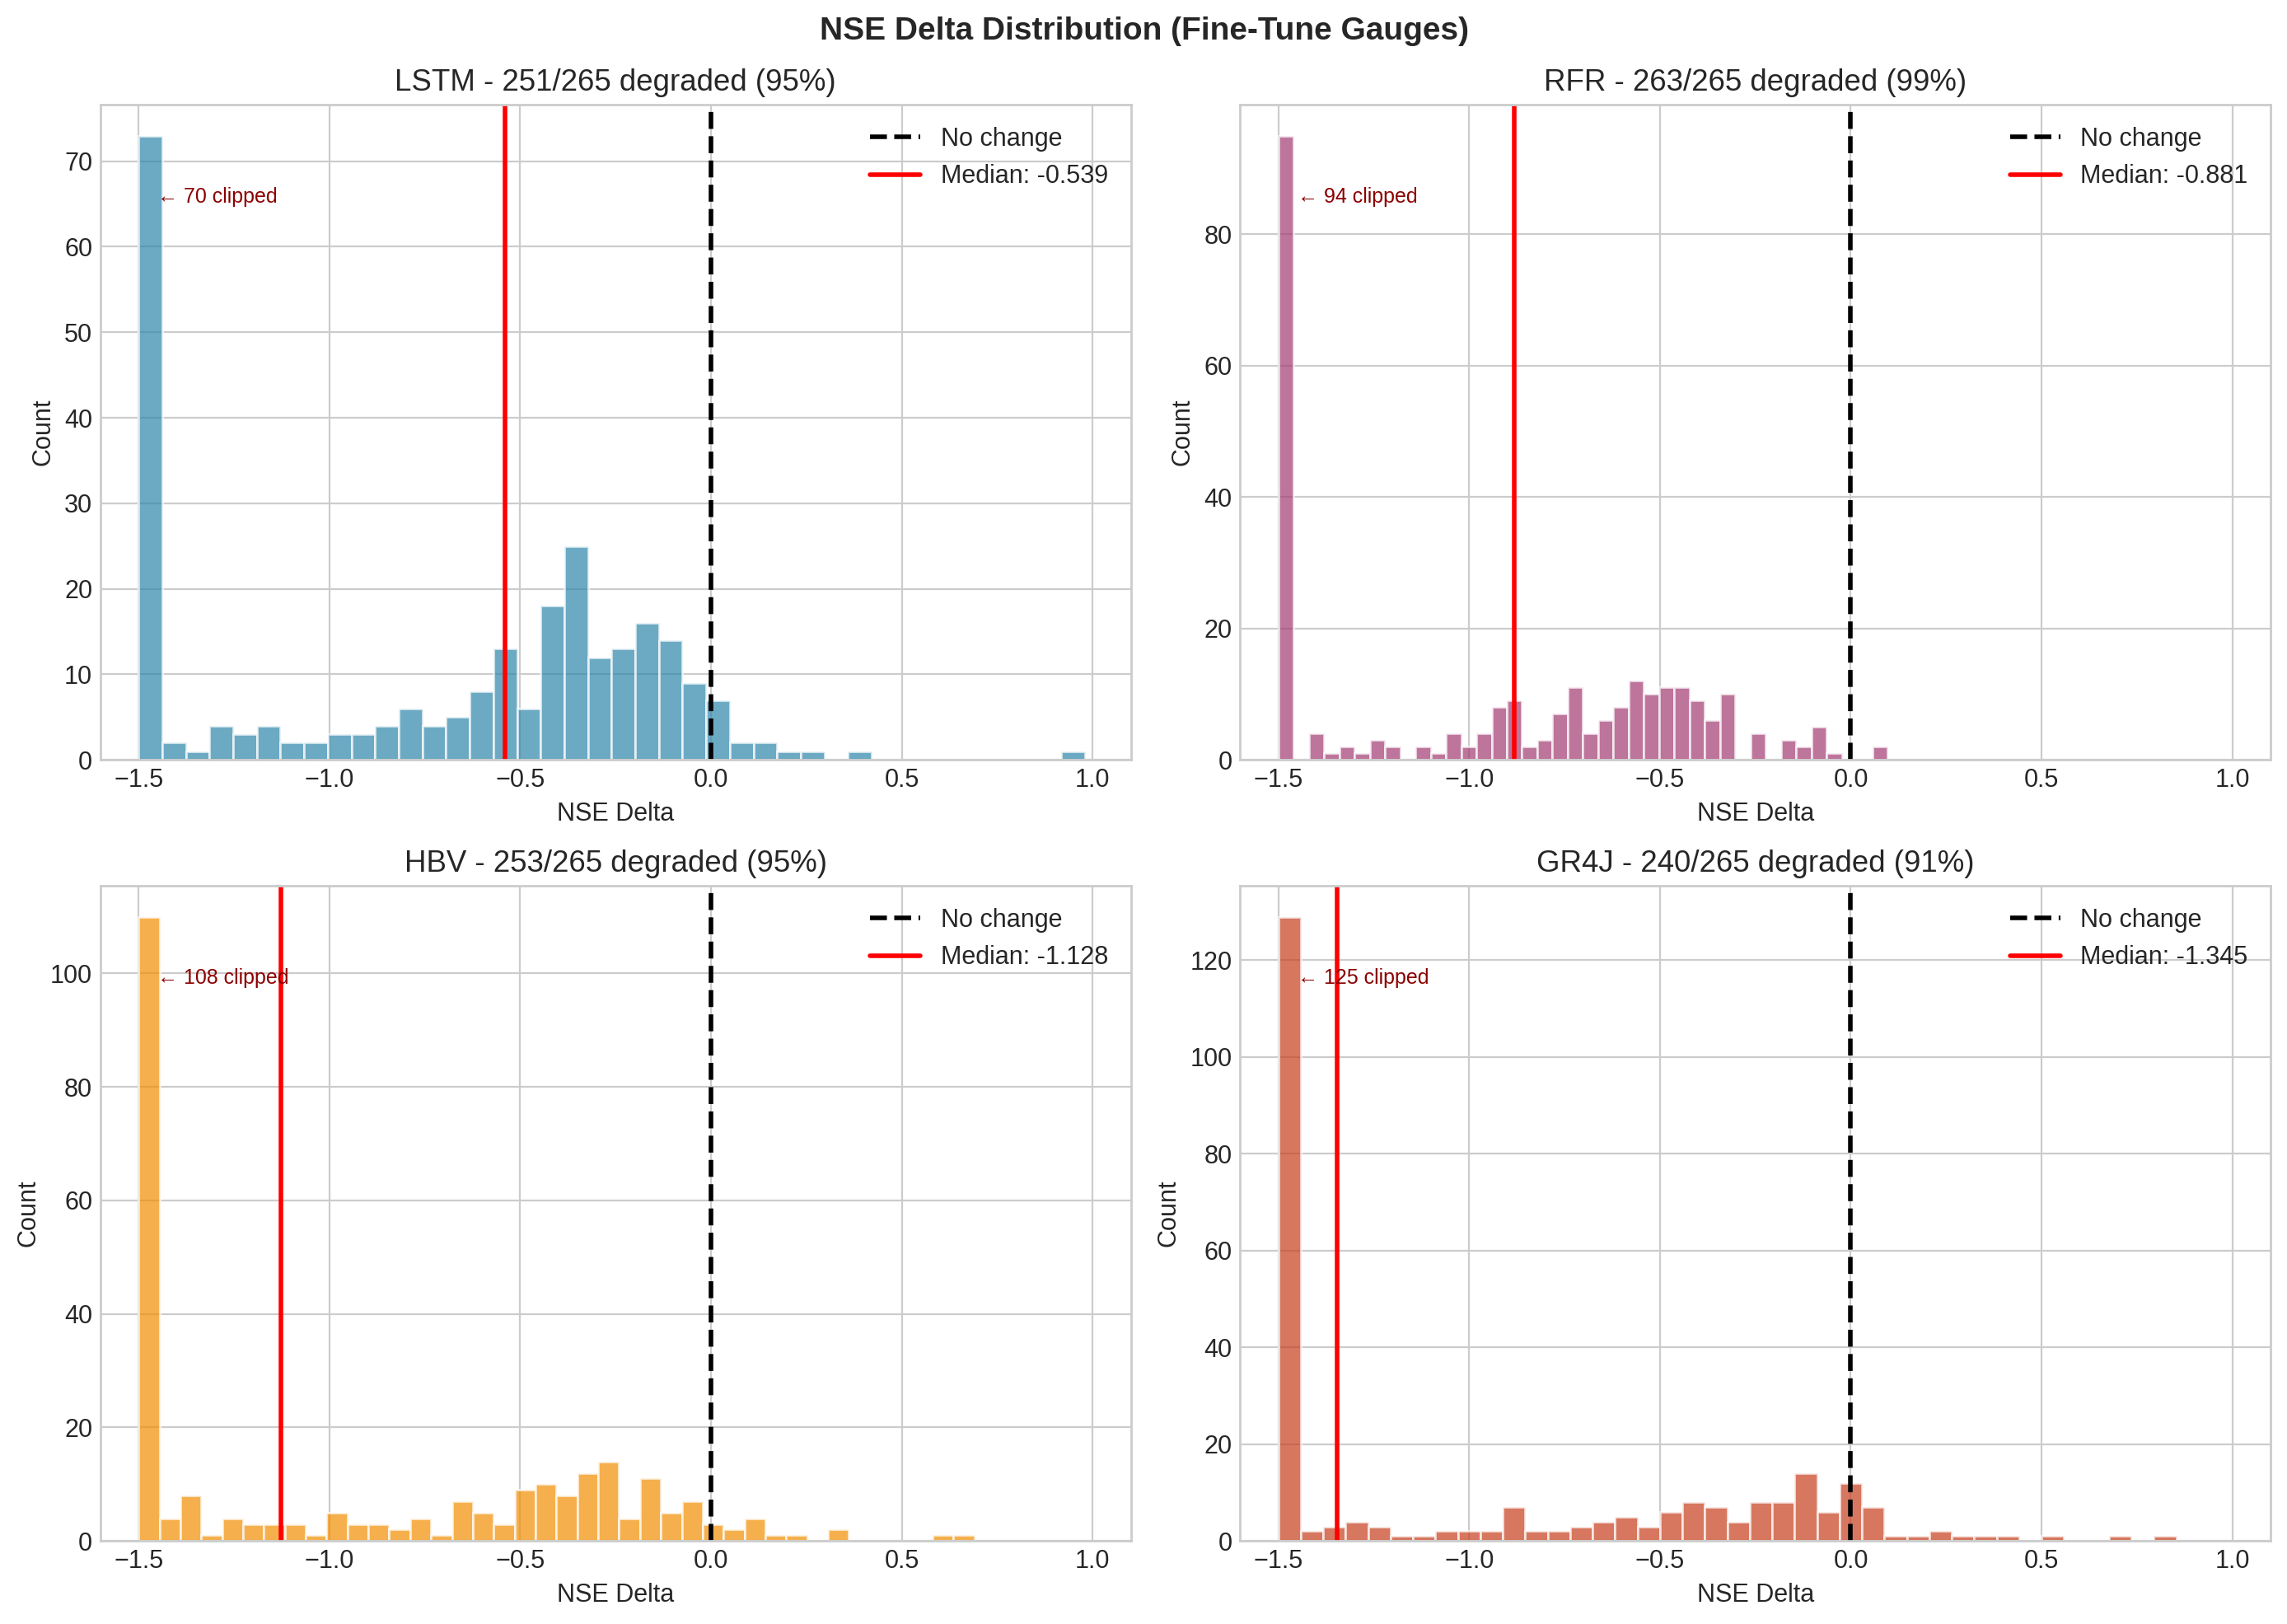

In [ ]:
# Create analysis dataframe with clipped values for viz
def create_analysis_df(model):
    delta = performance_delta[model].copy()
    idx = delta.index.intersection(static_attrs.index).intersection(hydro_clusters.index)
    delta = delta.loc[idx]
    for col in static_attrs.columns:
        delta[col] = static_attrs.loc[idx, col]
    delta["hydro_cluster"] = hydro_clusters.loc[idx, "Cluster_Name"]
    # Clipped versions for visualization
    delta["nse_delta_clip"] = delta["nse_delta"].clip(*DELTA_CLIP)
    delta["nse_train_clip"] = delta["nse_train"].clip(*NSE_CLIP)
    delta["nse_test_clip"] = delta["nse_test"].clip(*NSE_CLIP)
    return delta


analysis_dfs = {m: create_analysis_df(m) for m in MODELS}

# Plot NSE Delta distribution (clipped for viz, stats from raw)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, m in zip(axes.flat, MODELS):
    raw = performance_delta[m]["nse_delta"].dropna()
    clip = analysis_dfs[m]["nse_delta_clip"].dropna()
    n_out = ((raw < DELTA_CLIP[0]) | (raw > DELTA_CLIP[1])).sum()

    ax.hist(clip, bins=40, color=COLORS[m], alpha=0.7, edgecolor="white")
    ax.axvline(0, color="black", ls="--", lw=2, label="No change")
    ax.axvline(raw.median(), color="red", lw=2, label=f"Median: {raw.median():.3f}")
    if n_out > 0:
        ax.annotate(
            f"← {n_out} clipped",
            xy=(DELTA_CLIP[0] + 0.05, ax.get_ylim()[1] * 0.85),
            fontsize=9,
            color="darkred",
        )
    ax.set(
        xlabel="NSE Delta",
        ylabel="Count",
        xlim=(DELTA_CLIP[0] - 0.1, DELTA_CLIP[1] + 0.1),
    )
    ax.set_title(f"{m.upper()} - {(raw < 0).sum()}/{len(raw)} degraded ({(raw < 0).mean() * 100:.0f}%)")
    ax.legend(loc="upper right")

plt.suptitle("NSE Delta Distribution (Fine-Tune Gauges)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(RESULTS_PATH / "ft_nse_delta_distribution.png", dpi=150, bbox_inches="tight")
plt.show()


Using 19 standard features for geographical impact analysis:
  ['for_pc_use', 'crp_pc_use', 'inu_pc_ult', 'ire_pc_use', 'lka_pc_use', 'prm_pc_use', 'pst_pc_use', 'cly_pc_uav', 'slt_pc_uav', 'snd_pc_uav', 'kar_pc_use', 'urb_pc_use', 'gwt_cm_sav', 'lkv_mc_usu', 'rev_mc_usu', 'slp_dg_sav', 'sgr_dk_sav', 'ws_area', 'ele_mt_uav']
Spearman correlations: Static Attributes vs NSE Delta (LSTM)


,corr,pval,n,sig
pst_pc_use,-0.2879,0.0000,265.0,***
crp_pc_use,-0.1517,0.0134,265.0,*
ele_mt_uav,-0.1437,0.0193,265.0,*
slt_pc_uav,-0.1131,0.0659,265.0,
sgr_dk_sav,-0.1050,0.0879,265.0,
gwt_cm_sav,-0.0785,0.2026,265.0,
ws_area,-0.0589,0.3397,265.0,
ire_pc_use,-0.0525,0.3947,265.0,
cly_pc_uav,-0.0493,0.4243,265.0,
prm_pc_use,0.0077,0.9012,265.0,


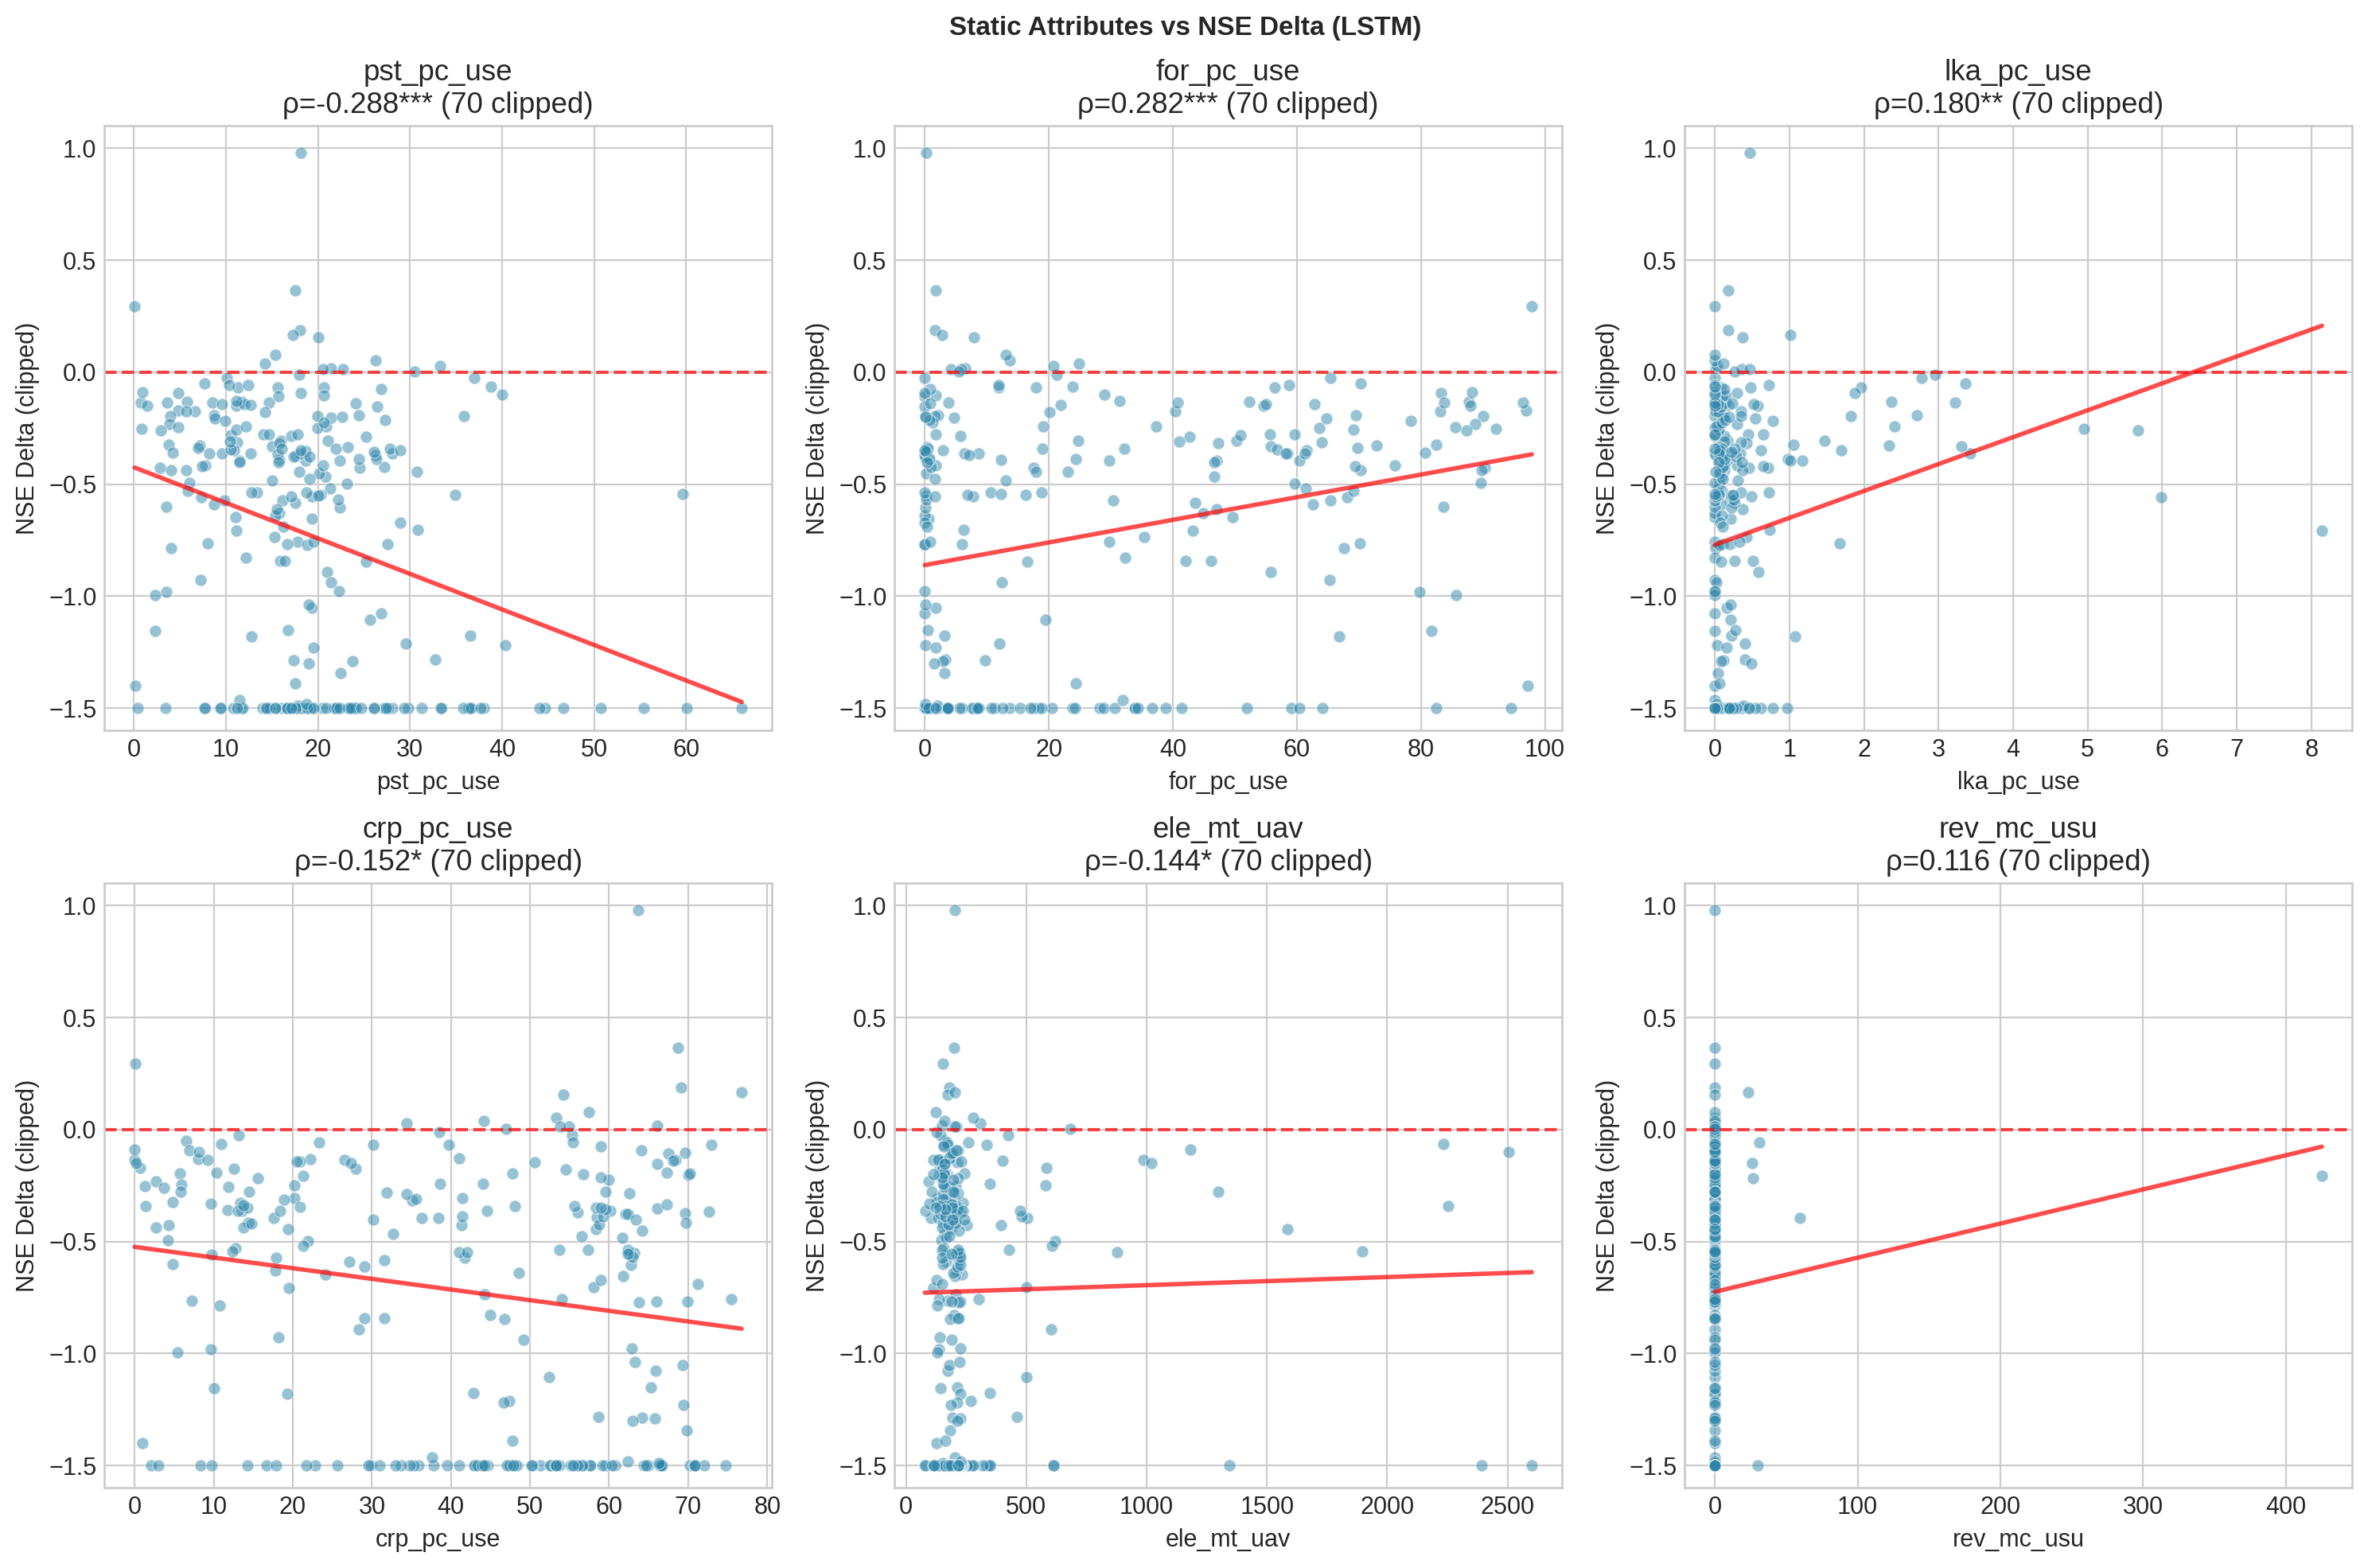

In [ ]:
# Static attribute correlations (using RAW delta values)
# Using STANDARD_FEATURES from src.constants.features for geographical analysis
print(f"Using {len(STANDARD_FEATURES)} standard features for geographical impact analysis:")
print(f"  {STANDARD_FEATURES}")

df = analysis_dfs["lstm"]
corrs = {}
for attr in STANDARD_FEATURES:
    if attr in df.columns:
        mask = ~df["nse_delta"].isna() & ~df[attr].isna()
        if mask.sum() > 20:
            c, p = stats.spearmanr(df.loc[mask, "nse_delta"], df.loc[mask, attr])
            corrs[attr] = {"corr": c, "pval": p, "n": mask.sum()}

corr_df = pd.DataFrame(corrs).T.sort_values("corr")
corr_df["sig"] = corr_df["pval"].apply(
    lambda p: "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
)
print("Spearman correlations: Static Attributes vs NSE Delta (LSTM)")
display(corr_df.round(4))

# Scatter plots for top 6 (using CLIPPED delta for viz)
top_attrs = corr_df.sort_values("corr", key=abs, ascending=False).head(6).index.tolist()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, attr in zip(axes.flat, top_attrs):
    x, y_raw, y_clip = df[attr], df["nse_delta"], df["nse_delta_clip"]
    mask = ~x.isna() & ~y_raw.isna()
    n_out = ((y_raw[mask] < DELTA_CLIP[0]) | (y_raw[mask] > DELTA_CLIP[1])).sum()

    ax.scatter(
        x[mask],
        y_clip[mask],
        alpha=0.5,
        s=30,
        c=COLORS["lstm"],
        edgecolor="white",
        lw=0.5,
    )
    ax.axhline(0, color="red", ls="--", alpha=0.7)
    z = np.polyfit(x[mask], y_clip[mask], 1)
    ax.plot(
        np.linspace(x[mask].min(), x[mask].max(), 100),
        np.poly1d(z)(np.linspace(x[mask].min(), x[mask].max(), 100)),
        "r-",
        lw=2,
        alpha=0.7,
    )

    c, sig = corr_df.loc[attr, "corr"], corr_df.loc[attr, "sig"]
    ax.set(
        xlabel=attr,
        ylabel="NSE Delta (clipped)",
        ylim=(DELTA_CLIP[0] - 0.1, DELTA_CLIP[1] + 0.1),
    )
    ax.set_title(f"{attr}\nρ={c:.3f}{sig}" + (f" ({n_out} clipped)" if n_out else ""))

plt.suptitle("Static Attributes vs NSE Delta (LSTM)", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig(RESULTS_PATH / "ft_static_attr_correlations.png", dpi=150, bbox_inches="tight")
plt.show()


Cluster Performance (sorted by worst):


,nse_train_mean,nse_train_count,nse_test_mean,nse_delta_mean,nse_delta_median,nse_delta_std,pct_degraded
hydro_cluster,,,,,,,
Г1,0.681,47,-95.169,-95.850,-1.463,599.174,95.744681
Г5,0.633,91,-1.341,-1.975,-0.554,8.889,94.505495
Г3,0.714,85,-0.783,-1.497,-0.539,2.344,94.117647
Г4,0.402,22,-0.955,-1.358,-0.392,2.430,90.909091
Г2,0.810,20,0.541,-0.269,-0.257,0.183,100.000000


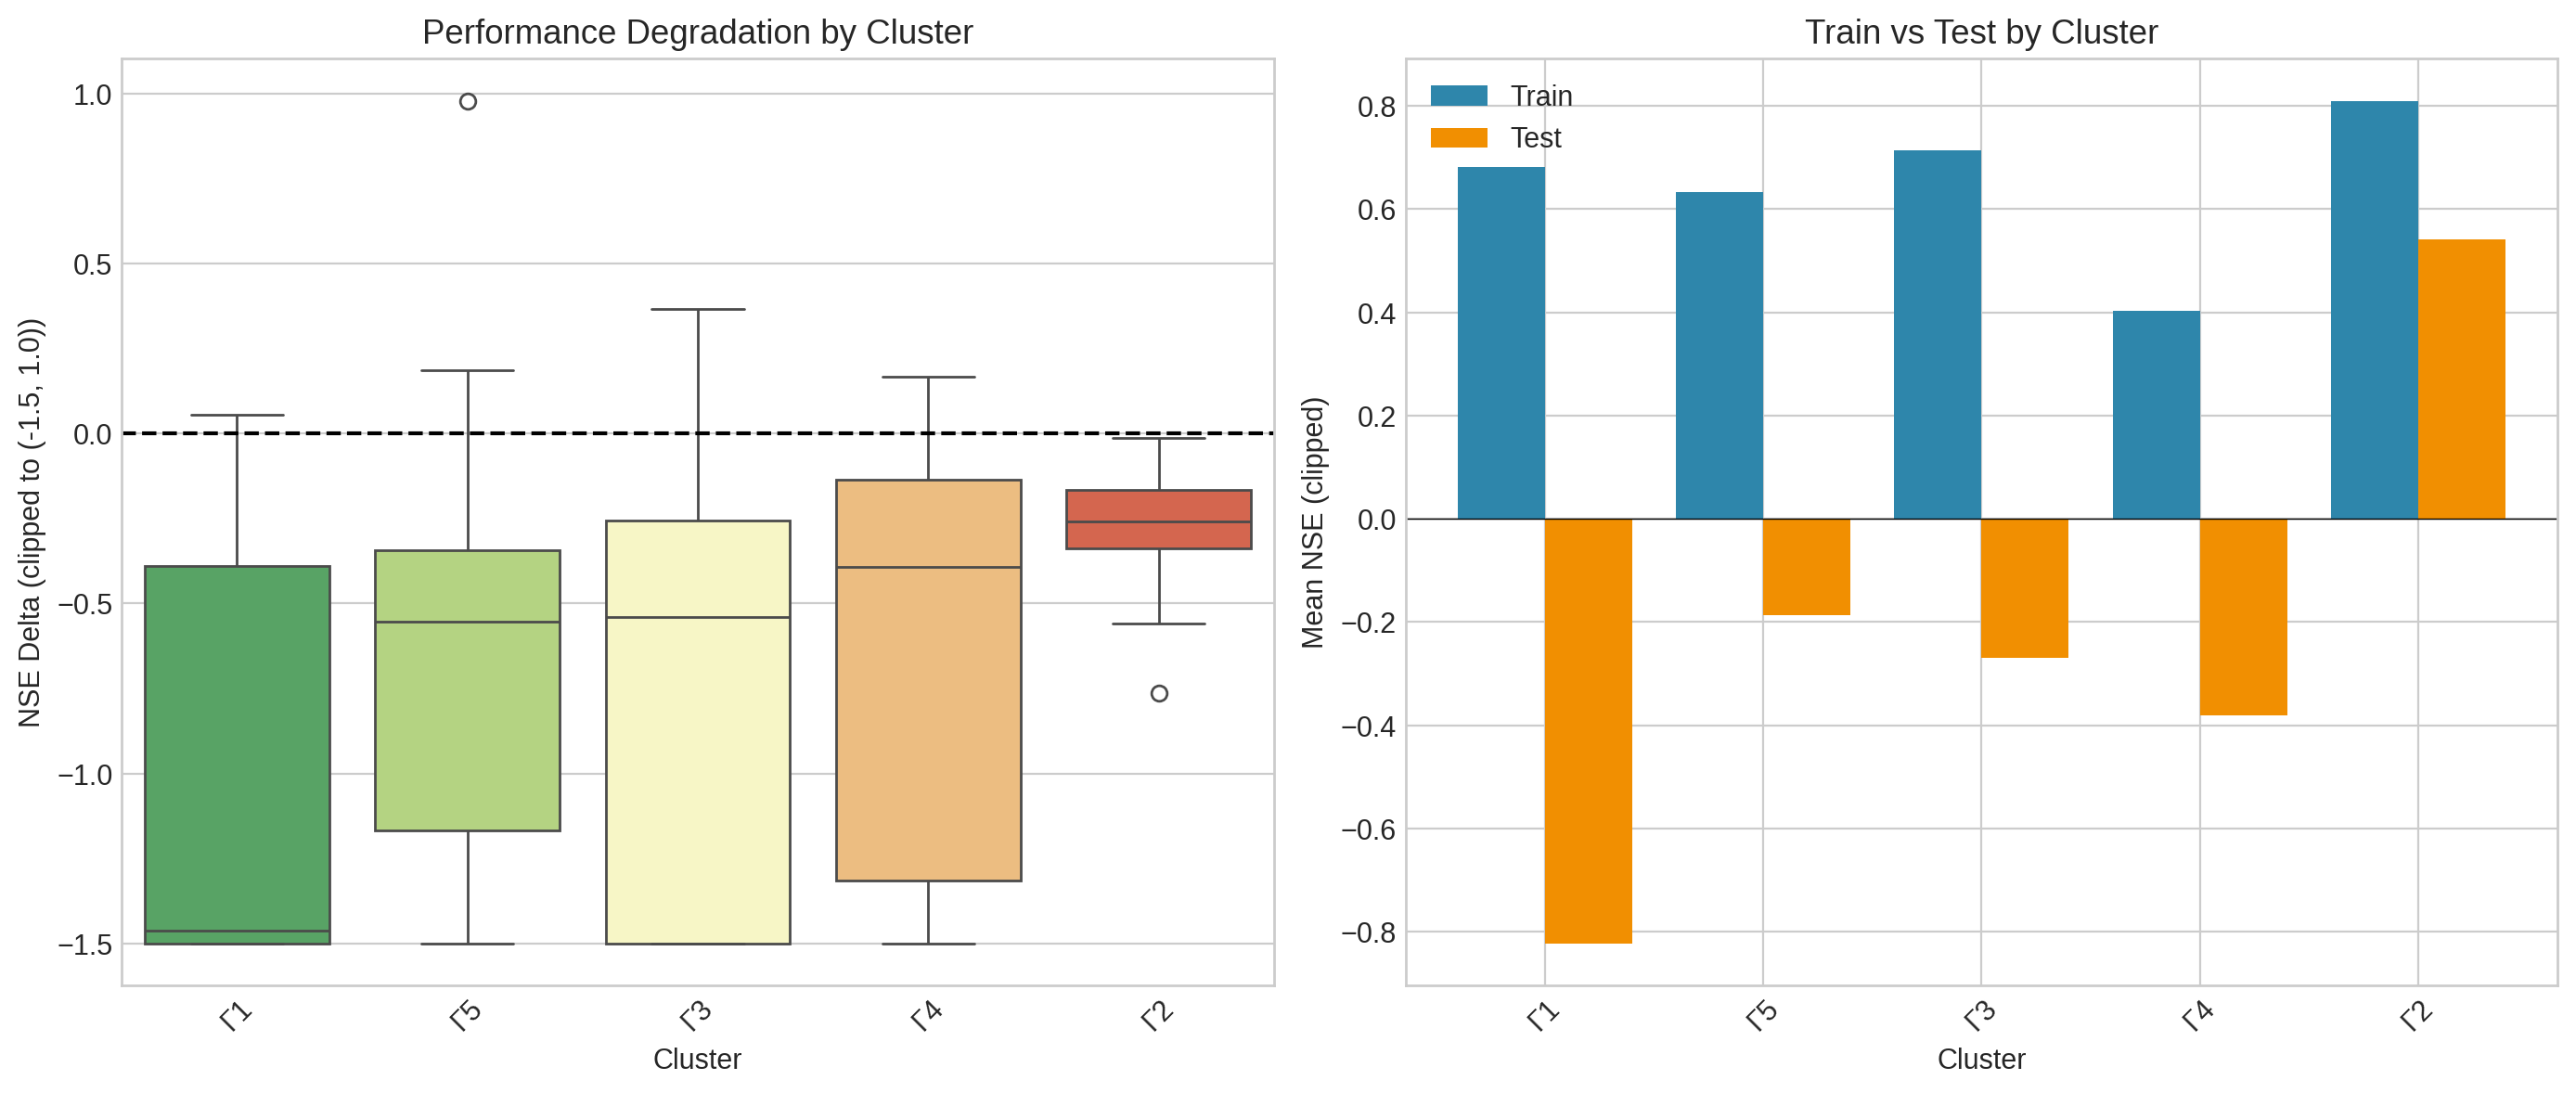

In [ ]:
# Cluster analysis (using RAW values for stats, clipped for viz)
df = analysis_dfs["lstm"]
cluster_stats = (
    df.groupby("hydro_cluster")
    .agg(
        {
            "nse_train": ["mean", "count"],
            "nse_test": ["mean"],
            "nse_delta": ["mean", "median", "std"],
        }
    )
    .round(3)
)
cluster_stats.columns = ["_".join(c) for c in cluster_stats.columns]
cluster_stats["pct_degraded"] = df.groupby("hydro_cluster").apply(
    lambda x: (x["nse_delta"] < 0).mean() * 100
)
cluster_stats = cluster_stats.sort_values("nse_delta_mean")
print("Cluster Performance (sorted by worst):")
display(cluster_stats)

# Boxplot + Bar chart (clipped for visualization)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
order = df.groupby("hydro_cluster")["nse_delta"].median().sort_values().index

sns.boxplot(
    data=df,
    x="hydro_cluster",
    y="nse_delta_clip",
    order=order,
    palette="RdYlGn_r",
    ax=axes[0],
)
axes[0].axhline(0, color="black", ls="--", lw=1.5)
axes[0].set(
    xlabel="Cluster",
    ylabel=f"NSE Delta (clipped to {DELTA_CLIP})",
    title="Performance Degradation by Cluster",
)
axes[0].tick_params(axis="x", rotation=45)

means = df.groupby("hydro_cluster")[["nse_train_clip", "nse_test_clip"]].mean().loc[order]
x = np.arange(len(order))
axes[1].bar(x - 0.2, means["nse_train_clip"], 0.4, label="Train", color=COLORS["lstm"])
axes[1].bar(x + 0.2, means["nse_test_clip"], 0.4, label="Test", color=COLORS["hbv"])
axes[1].set_xticks(x)
axes[1].set_xticklabels(order, rotation=45)
axes[1].set(xlabel="Cluster", ylabel="Mean NSE (clipped)", title="Train vs Test by Cluster")
axes[1].legend()
axes[1].axhline(0, color="black", lw=0.5)

plt.tight_layout()
plt.savefig(RESULTS_PATH / "ft_cluster_performance.png", dpi=150, bbox_inches="tight")
plt.show()


Discharge analysis:   0%|          | 0/265 [00:00<?, ?it/s]


DISCHARGE PATTERN SHIFTS
Mean change: -22.9% (median)
Std change: -59.7% (median)
Gauges with >20% decrease in mean: 147


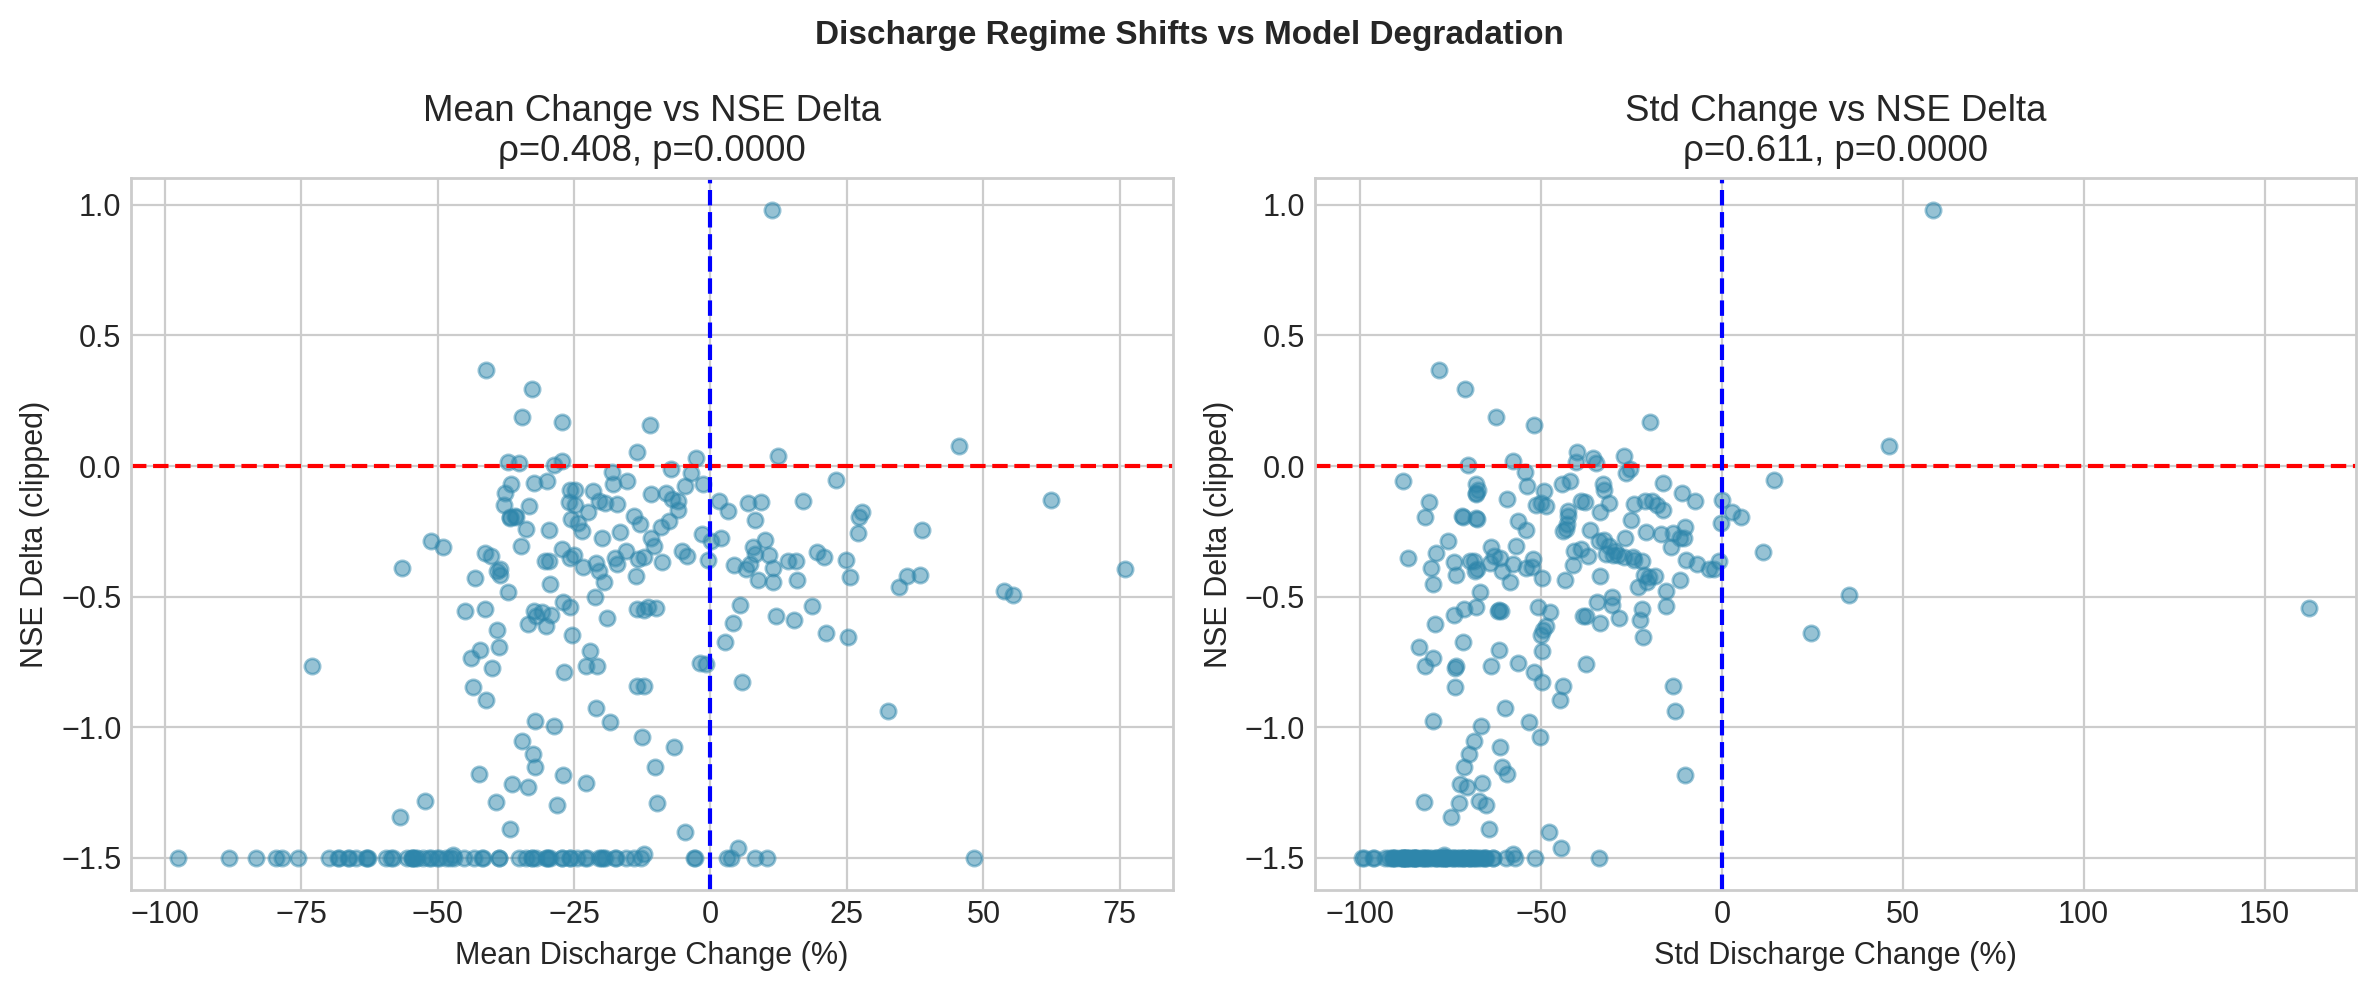

In [ ]:
# Discharge pattern analysis - detect regime shifts
def analyze_discharge(preds, gauges):
    res = []
    for g in tqdm(gauges, desc="Discharge analysis", leave=False):
        if g not in preds:
            continue
        tr = preds[g].loc[TRAIN_START:TRAIN_END, "q_obs"]
        te = preds[g].loc[TEST_START:TEST_END, "q_obs"]
        if len(tr) < 100 or len(te) < 100:
            continue
        res.append(
            {
                "gauge_id": g,
                "train_mean": tr.mean(),
                "test_mean": te.mean(),
                "train_std": tr.std(),
                "test_std": te.std(),
                "mean_change_pct": 100 * (te.mean() - tr.mean()) / tr.mean()
                if tr.mean() > 0
                else np.nan,
                "std_change_pct": 100 * (te.std() - tr.std()) / tr.std() if tr.std() > 0 else np.nan,
            }
        )
    return pd.DataFrame(res).set_index("gauge_id")


discharge = analyze_discharge(model_predictions["lstm"], common_gauges)
print("\nDISCHARGE PATTERN SHIFTS")
print(f"Mean change: {discharge['mean_change_pct'].median():.1f}% (median)")
print(f"Std change: {discharge['std_change_pct'].median():.1f}% (median)")
print(f"Gauges with >20% decrease in mean: {(discharge['mean_change_pct'] < -20).sum()}")

# Correlation with NSE delta
merged = analysis_dfs["lstm"].join(discharge, how="inner")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, col, lbl in zip(axes, ["mean_change_pct", "std_change_pct"], ["Mean", "Std"]):
    y_clip = merged["nse_delta_clip"]
    mask = ~merged[col].isna() & ~merged["nse_delta"].isna()
    ax.scatter(merged.loc[mask, col], y_clip[mask], alpha=0.5, s=30, c=COLORS["lstm"])
    ax.axhline(0, color="red", ls="--")
    ax.axvline(0, color="blue", ls="--")
    c, p = stats.spearmanr(merged.loc[mask, col], merged.loc[mask, "nse_delta"])
    ax.set(xlabel=f"{lbl} Discharge Change (%)", ylabel="NSE Delta (clipped)")
    ax.set_title(f"{lbl} Change vs NSE Delta\nρ={c:.3f}, p={p:.4f}")
plt.suptitle("Discharge Regime Shifts vs Model Degradation", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig(RESULTS_PATH / "ft_discharge_impact.png", dpi=150, bbox_inches="tight")
plt.show()


In [ ]:
# Summary Report
print("=" * 80 + "\nFINE-TUNE GAUGES: GENERALIZATION GAP SUMMARY\n" + "=" * 80)
print(f"\nN = {len(common_gauges)} gauges analyzed")

print("\n1. PERFORMANCE BY MODEL")
for m in MODELS:
    d = performance_delta[m]
    print(
        f"  {m.upper()}: Train={d['nse_train'].median():.2f} → Test={d['nse_test'].median():.2f} "
        f"(Δ={d['nse_delta'].median():.2f}), {(d['nse_delta'] < 0).mean() * 100:.0f}% degraded"
    )

print("\n2. WORST CLUSTERS")
for cl in cluster_stats.head(3).index:
    info = cluster_stats.loc[cl]
    print(f"  {cl}: Δmean={info['nse_delta_mean']:.2f}, {info['pct_degraded']:.0f}% degraded")
    if cl in hydro_cluster_info:
        print(f"    → {hydro_cluster_info[cl]['regime_type']}")

print("\n3. SIGNIFICANT ATTRIBUTE CORRELATIONS")
sig = corr_df[corr_df["pval"] < 0.05]
for attr in sig.head(4).index:
    direction = "worse" if sig.loc[attr, "corr"] < 0 else "better"
    print(f"  {attr}: ρ={sig.loc[attr, 'corr']:.3f} (higher → {direction})")

print("\n4. HYPOTHESES")
print("  a) CLIMATE SHIFT: Discharge dropped ~23% between periods")
print("  b) REGIME VULNERABILITY: Spring flood catchments most affected")
print("  c) ATTRIBUTE EFFECTS: Cropland/elevation → worse; Forest/lakes → better")


FINE-TUNE GAUGES: GENERALIZATION GAP SUMMARY

N = 265 gauges analyzed

1. PERFORMANCE BY MODEL
  LSTM: Train=0.72 → Test=0.12 (Δ=-0.54), 95% degraded
  RFR: Train=0.75 → Test=-0.10 (Δ=-0.88), 99% degraded
  HBV: Train=0.60 → Test=-0.52 (Δ=-1.13), 95% degraded
  GR4J: Train=0.51 → Test=-0.85 (Δ=-1.35), 91% degraded

2. WORST CLUSTERS
  Г1: Δmean=-95.85, 96% degraded
    → Весеннее половодье (паводочный)
  Г5: Δmean=-1.98, 95% degraded
    → Весеннее половодье (паводочный)
  Г3: Δmean=-1.50, 94% degraded
    → Весеннее половодье (паводочный)

3. SIGNIFICANT ATTRIBUTE CORRELATIONS
  pst_pc_use: ρ=-0.288 (higher → worse)
  crp_pc_use: ρ=-0.152 (higher → worse)
  ele_mt_uav: ρ=-0.144 (higher → worse)
  lka_pc_use: ρ=0.180 (higher → better)

4. HYPOTHESES
  a) CLIMATE SHIFT: Discharge dropped ~23% between periods
  b) REGIME VULNERABILITY: Spring flood catchments most affected
  c) ATTRIBUTE EFFECTS: Cropland/elevation → worse; Forest/lakes → better


In [10]:
# Save results
ft_metrics = pd.DataFrame(index=common_gauges)
for m in MODELS:
    ft_metrics[f"{m}_nse_train"] = performance_delta[m].loc[common_gauges, "nse_train"]
    ft_metrics[f"{m}_nse_test"] = performance_delta[m].loc[common_gauges, "nse_test"]
    ft_metrics[f"{m}_nse_delta"] = performance_delta[m].loc[common_gauges, "nse_delta"]
ft_metrics["hydro_cluster"] = hydro_clusters.loc[common_gauges, "Cluster_Name"]

ft_metrics.to_csv(RESULTS_PATH / "fine_tune_all_metrics.csv")
cluster_stats.to_csv(RESULTS_PATH / "fine_tune_cluster_stats.csv")
corr_df.to_csv(RESULTS_PATH / "fine_tune_correlations.csv")
discharge.to_csv(RESULTS_PATH / "fine_tune_discharge_changes.csv")

print(f"\nSaved to {RESULTS_PATH}:")
for f in [
    "fine_tune_all_metrics.csv",
    "fine_tune_cluster_stats.csv",
    "fine_tune_correlations.csv",
    "fine_tune_discharge_changes.csv",
]:
    print(f"  - {f}")



Saved to ../res/chapter_two:
  - fine_tune_all_metrics.csv
  - fine_tune_cluster_stats.csv
  - fine_tune_correlations.csv
  - fine_tune_discharge_changes.csv


---
# Comparative Analysis: Fine-Tune vs Good Gauges

**Goal**: Identify what makes fine-tune gauges different from well-performing gauges to understand WHY they fail.


In [11]:
# Define "good" gauges - all gauges NOT in fine-tune subset
all_gauges = sorted(
    set.intersection(*[set(model_predictions[m].keys()) for m in MODELS])
    & set(hydro_clusters.index)
    & set(static_attrs.index)
)
good_gauges = sorted(set(all_gauges) - set(ft_index))

print(f"Total gauges with complete data: {len(all_gauges)}")
print(f"  - Fine-tune (poor performers): {len(common_gauges)}")
print(f"  - Good performers: {len(good_gauges)}")

# Compute metrics for good gauges
perf_good = {}
for m in MODELS:
    train = compute_metrics(model_predictions[m], good_gauges, TRAIN_START, TRAIN_END)
    test = compute_metrics(model_predictions[m], good_gauges, TEST_START, TEST_END)
    idx = train.index.intersection(test.index)
    perf_good[m] = pd.DataFrame(
        {
            "nse_train": train.loc[idx, "nse"],
            "nse_test": test.loc[idx, "nse"],
            "nse_delta": test.loc[idx, "nse"] - train.loc[idx, "nse"],
        },
        index=idx,
    )

# Compare performance
print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON: Fine-Tune vs Good Gauges")
print("=" * 70)
for m in MODELS:
    ft_d = performance_delta[m]["nse_delta"]
    gd_d = perf_good[m]["nse_delta"]
    print(f"\n{m.upper()}:")
    print(
        f"  Fine-Tune: Train={performance_delta[m]['nse_train'].median():.2f} → Test={performance_delta[m]['nse_test'].median():.2f} (Δ={ft_d.median():.2f})"
    )
    print(
        f"  Good:      Train={perf_good[m]['nse_train'].median():.2f} → Test={perf_good[m]['nse_test'].median():.2f} (Δ={gd_d.median():.2f})"
    )
    print(f"  Gap: Fine-tune degrades {abs(ft_d.median() - gd_d.median()):.2f} more")


Total gauges with complete data: 996
  - Fine-tune (poor performers): 265
  - Good performers: 731

PERFORMANCE COMPARISON: Fine-Tune vs Good Gauges

LSTM:
  Fine-Tune: Train=0.72 → Test=0.12 (Δ=-0.54)
  Good:      Train=0.83 → Test=0.70 (Δ=-0.12)
  Gap: Fine-tune degrades 0.42 more

RFR:
  Fine-Tune: Train=0.75 → Test=-0.10 (Δ=-0.88)
  Good:      Train=0.92 → Test=0.65 (Δ=-0.26)
  Gap: Fine-tune degrades 0.62 more

HBV:
  Fine-Tune: Train=0.60 → Test=-0.52 (Δ=-1.13)
  Good:      Train=0.73 → Test=0.64 (Δ=-0.06)
  Gap: Fine-tune degrades 1.07 more

GR4J:
  Fine-Tune: Train=0.51 → Test=-0.85 (Δ=-1.35)
  Good:      Train=0.66 → Test=0.58 (Δ=-0.06)
  Gap: Fine-tune degrades 1.28 more


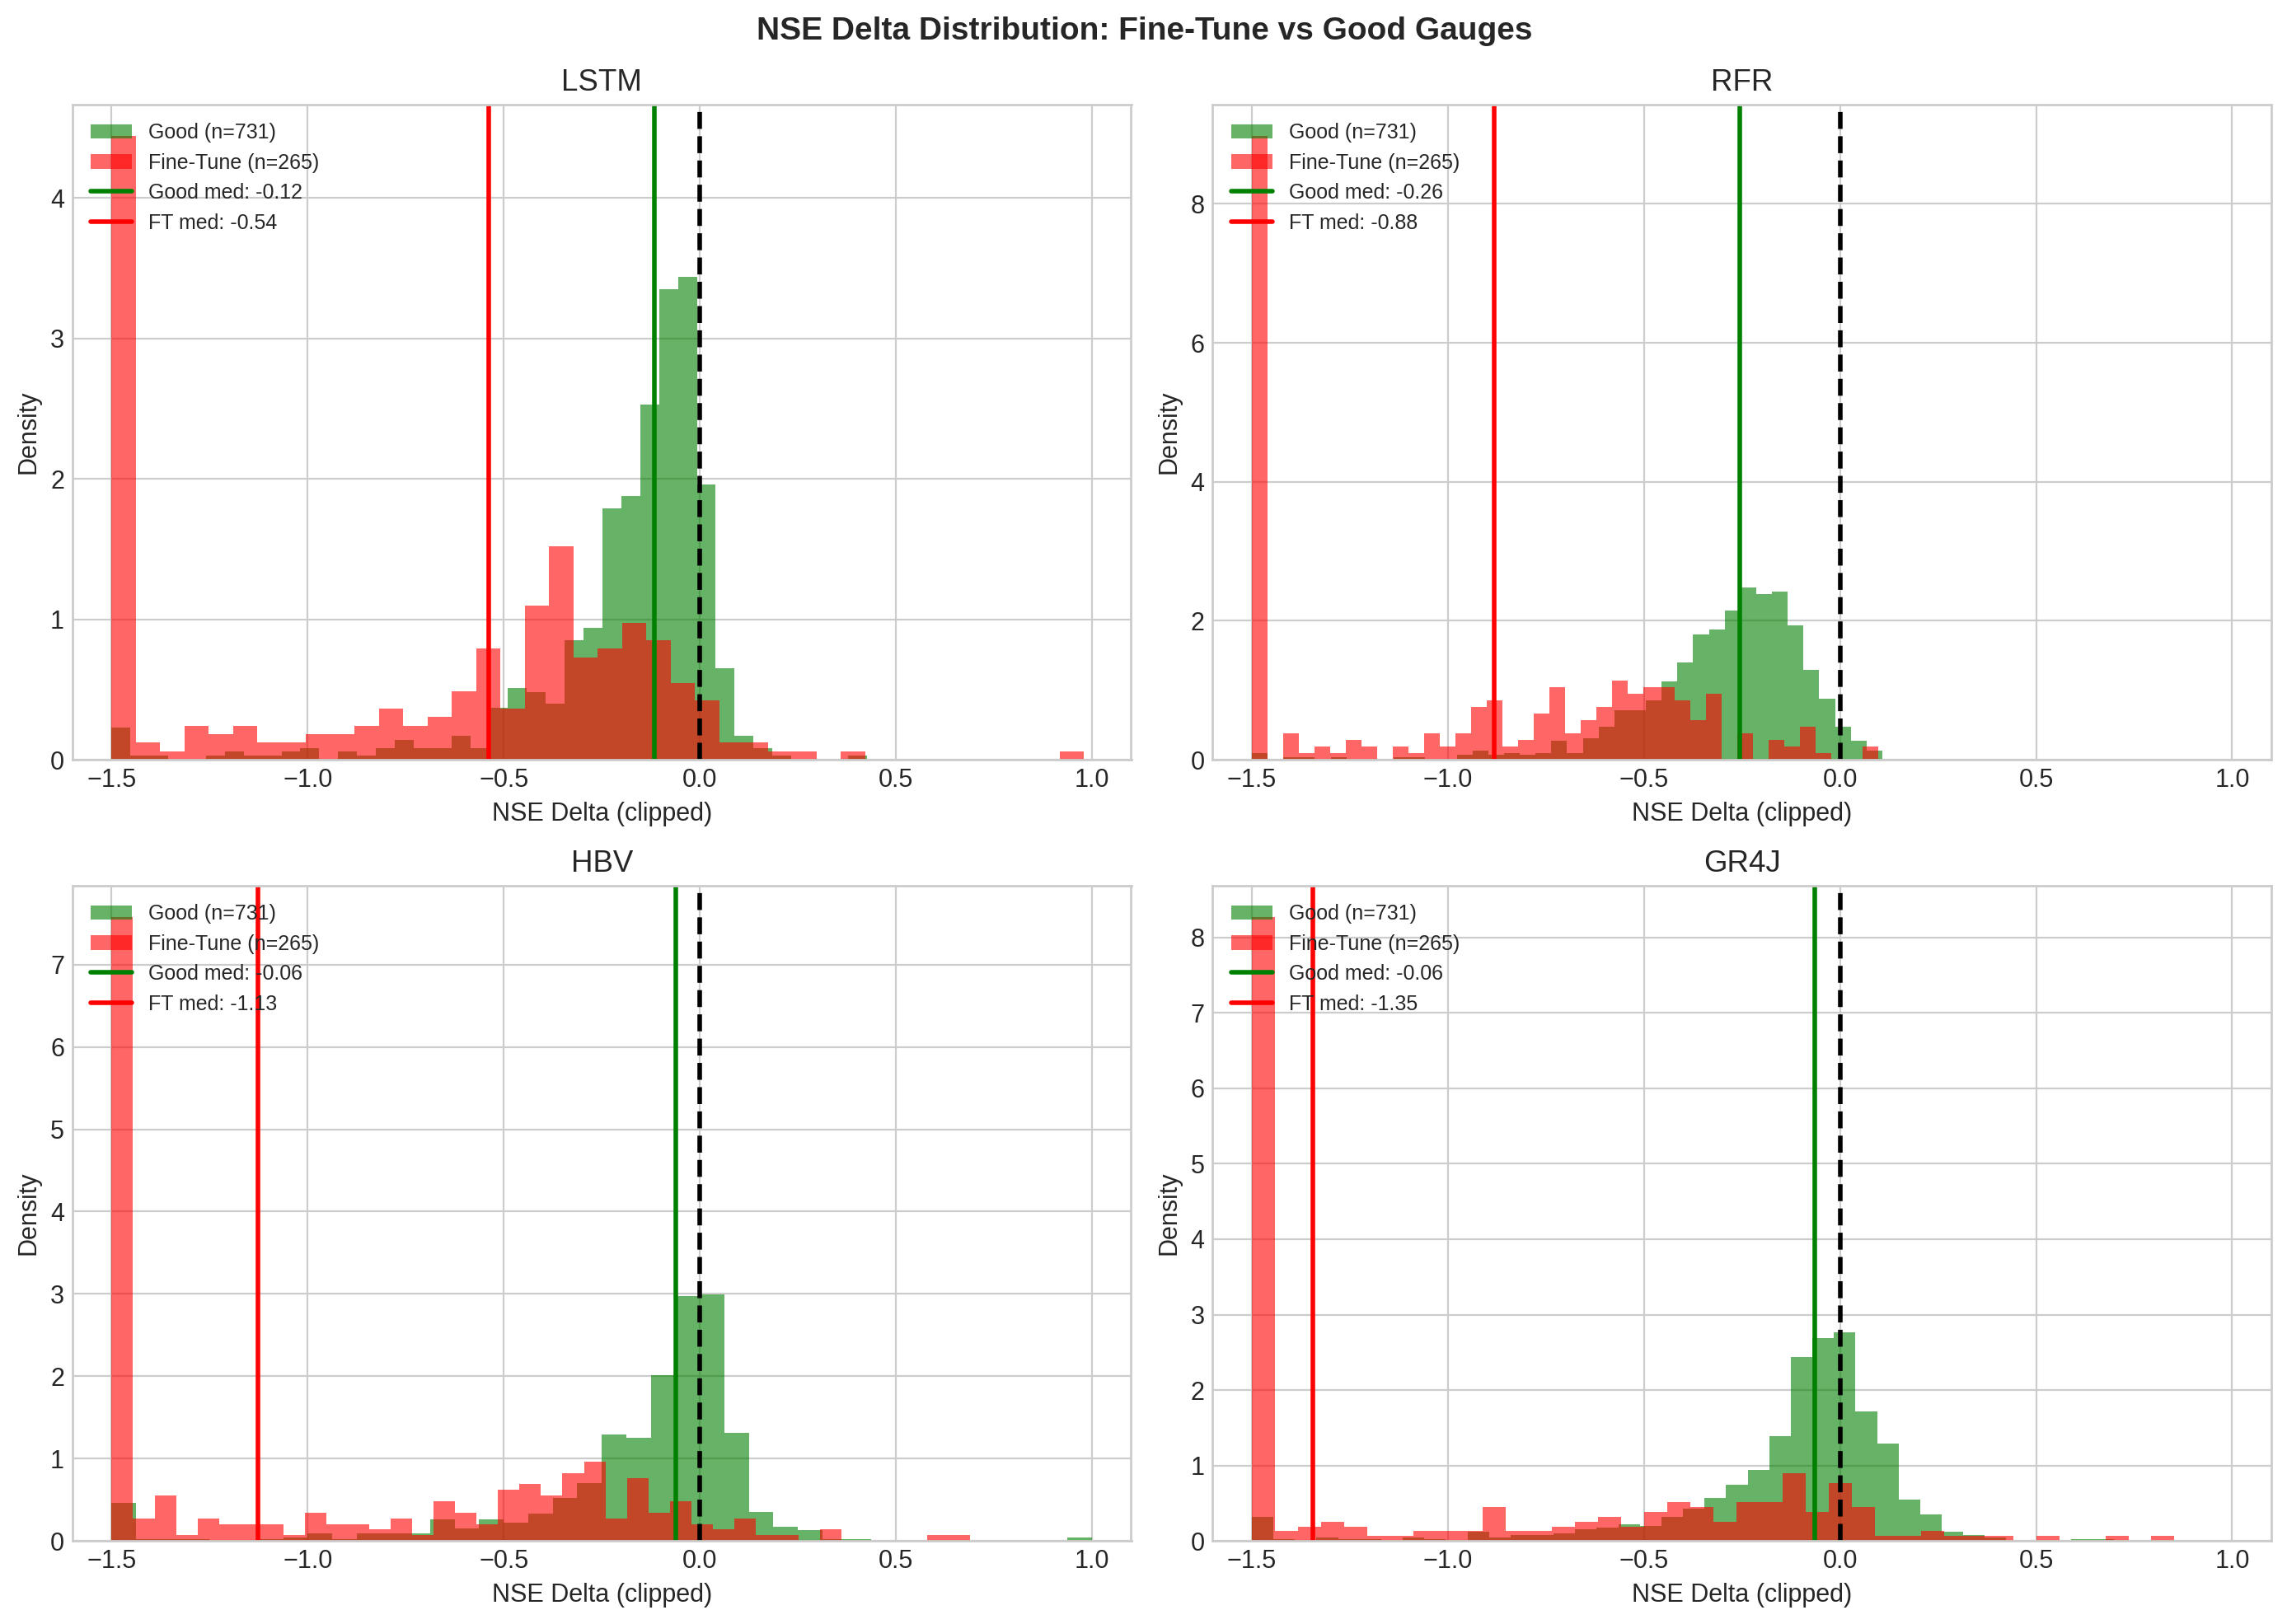

In [ ]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, m in zip(axes.flat, MODELS):
    ft_delta = performance_delta[m]["nse_delta"].clip(*DELTA_CLIP)
    gd_delta = perf_good[m]["nse_delta"].clip(*DELTA_CLIP)

    # Overlapping histograms
    ax.hist(
        gd_delta,
        bins=40,
        alpha=0.6,
        color="green",
        label=f"Good (n={len(gd_delta)})",
        density=True,
    )
    ax.hist(
        ft_delta,
        bins=40,
        alpha=0.6,
        color="red",
        label=f"Fine-Tune (n={len(ft_delta)})",
        density=True,
    )
    ax.axvline(0, color="black", ls="--", lw=2)
    ax.axvline(
        gd_delta.median(),
        color="green",
        ls="-",
        lw=2,
        label=f"Good med: {perf_good[m]['nse_delta'].median():.2f}",
    )
    ax.axvline(
        ft_delta.median(),
        color="red",
        ls="-",
        lw=2,
        label=f"FT med: {performance_delta[m]['nse_delta'].median():.2f}",
    )

    ax.set(xlabel="NSE Delta (clipped)", ylabel="Density", xlim=(-1.6, 1.1))
    ax.set_title(f"{m.upper()}")
    ax.legend(loc="upper left", fontsize=9)

plt.suptitle("NSE Delta Distribution: Fine-Tune vs Good Gauges", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(RESULTS_PATH / "comparison_ft_vs_good_delta.png", dpi=150, bbox_inches="tight")
plt.show()


In [ ]:
# Compare static attributes between groups (using STANDARD_FEATURES)
# Filter to features that exist in the dataset
available_features = [f for f in STANDARD_FEATURES if f in static_attrs.columns]
print(f"Using {len(available_features)}/{len(STANDARD_FEATURES)} standard features available in dataset")

ft_attrs = static_attrs.loc[static_attrs.index.isin(common_gauges), available_features]
gd_attrs = static_attrs.loc[static_attrs.index.isin(good_gauges), available_features]

comparison = pd.DataFrame(
    {
        "Fine-Tune Mean": ft_attrs.mean(),
        "Good Mean": gd_attrs.mean(),
        "Fine-Tune Median": ft_attrs.median(),
        "Good Median": gd_attrs.median(),
    }
)

# Statistical test (Mann-Whitney U) for each attribute
for attr in available_features:
    if attr in ft_attrs.columns and attr in gd_attrs.columns:
        ft_vals = ft_attrs[attr].dropna()
        gd_vals = gd_attrs[attr].dropna()
        if len(ft_vals) > 10 and len(gd_vals) > 10:
            stat, pval = stats.mannwhitneyu(ft_vals, gd_vals, alternative="two-sided")
            comparison.loc[attr, "p-value"] = pval
            comparison.loc[attr, "significant"] = (
                "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
            )

# Calculate % difference
comparison["% Diff (FT vs Good)"] = (
    (comparison["Fine-Tune Mean"] - comparison["Good Mean"]) / comparison["Good Mean"] * 100
).round(1)

print("STATIC ATTRIBUTE COMPARISON: Fine-Tune vs Good Gauges")
print("Positive % Diff = Fine-tune gauges have HIGHER values")
print("=" * 80)
display(comparison.sort_values("p-value").round(3))


Using 19/19 standard features available in dataset
STATIC ATTRIBUTE COMPARISON: Fine-Tune vs Good Gauges
Positive % Diff = Fine-tune gauges have HIGHER values


,Fine-Tune Mean,Good Mean,Fine-Tune Median,Good Median,p-value,significant,% Diff (FT vs Good)
crp_pc_use,41.382,5.955,46.644,0.376,0.000,***,594.9
pst_pc_use,18.683,4.640,17.830,0.560,0.000,***,302.7
for_pc_use,27.795,72.085,13.711,81.565,0.000,***,-61.4
prm_pc_use,0.377,15.133,0.000,0.991,0.000,***,-97.5
cly_pc_uav,17.510,12.132,17.818,12.635,0.000,***,44.3
slp_dg_sav,2.271,6.120,1.450,4.109,0.000,***,-62.9
urb_pc_use,1.191,0.464,0.363,0.000,0.000,***,156.6
sgr_dk_sav,52.332,111.108,29.442,68.565,0.000,***,-52.9
snd_pc_uav,38.679,46.171,37.003,45.467,0.000,***,-16.2
ire_pc_use,0.234,0.025,0.000,0.000,0.000,***,836.9


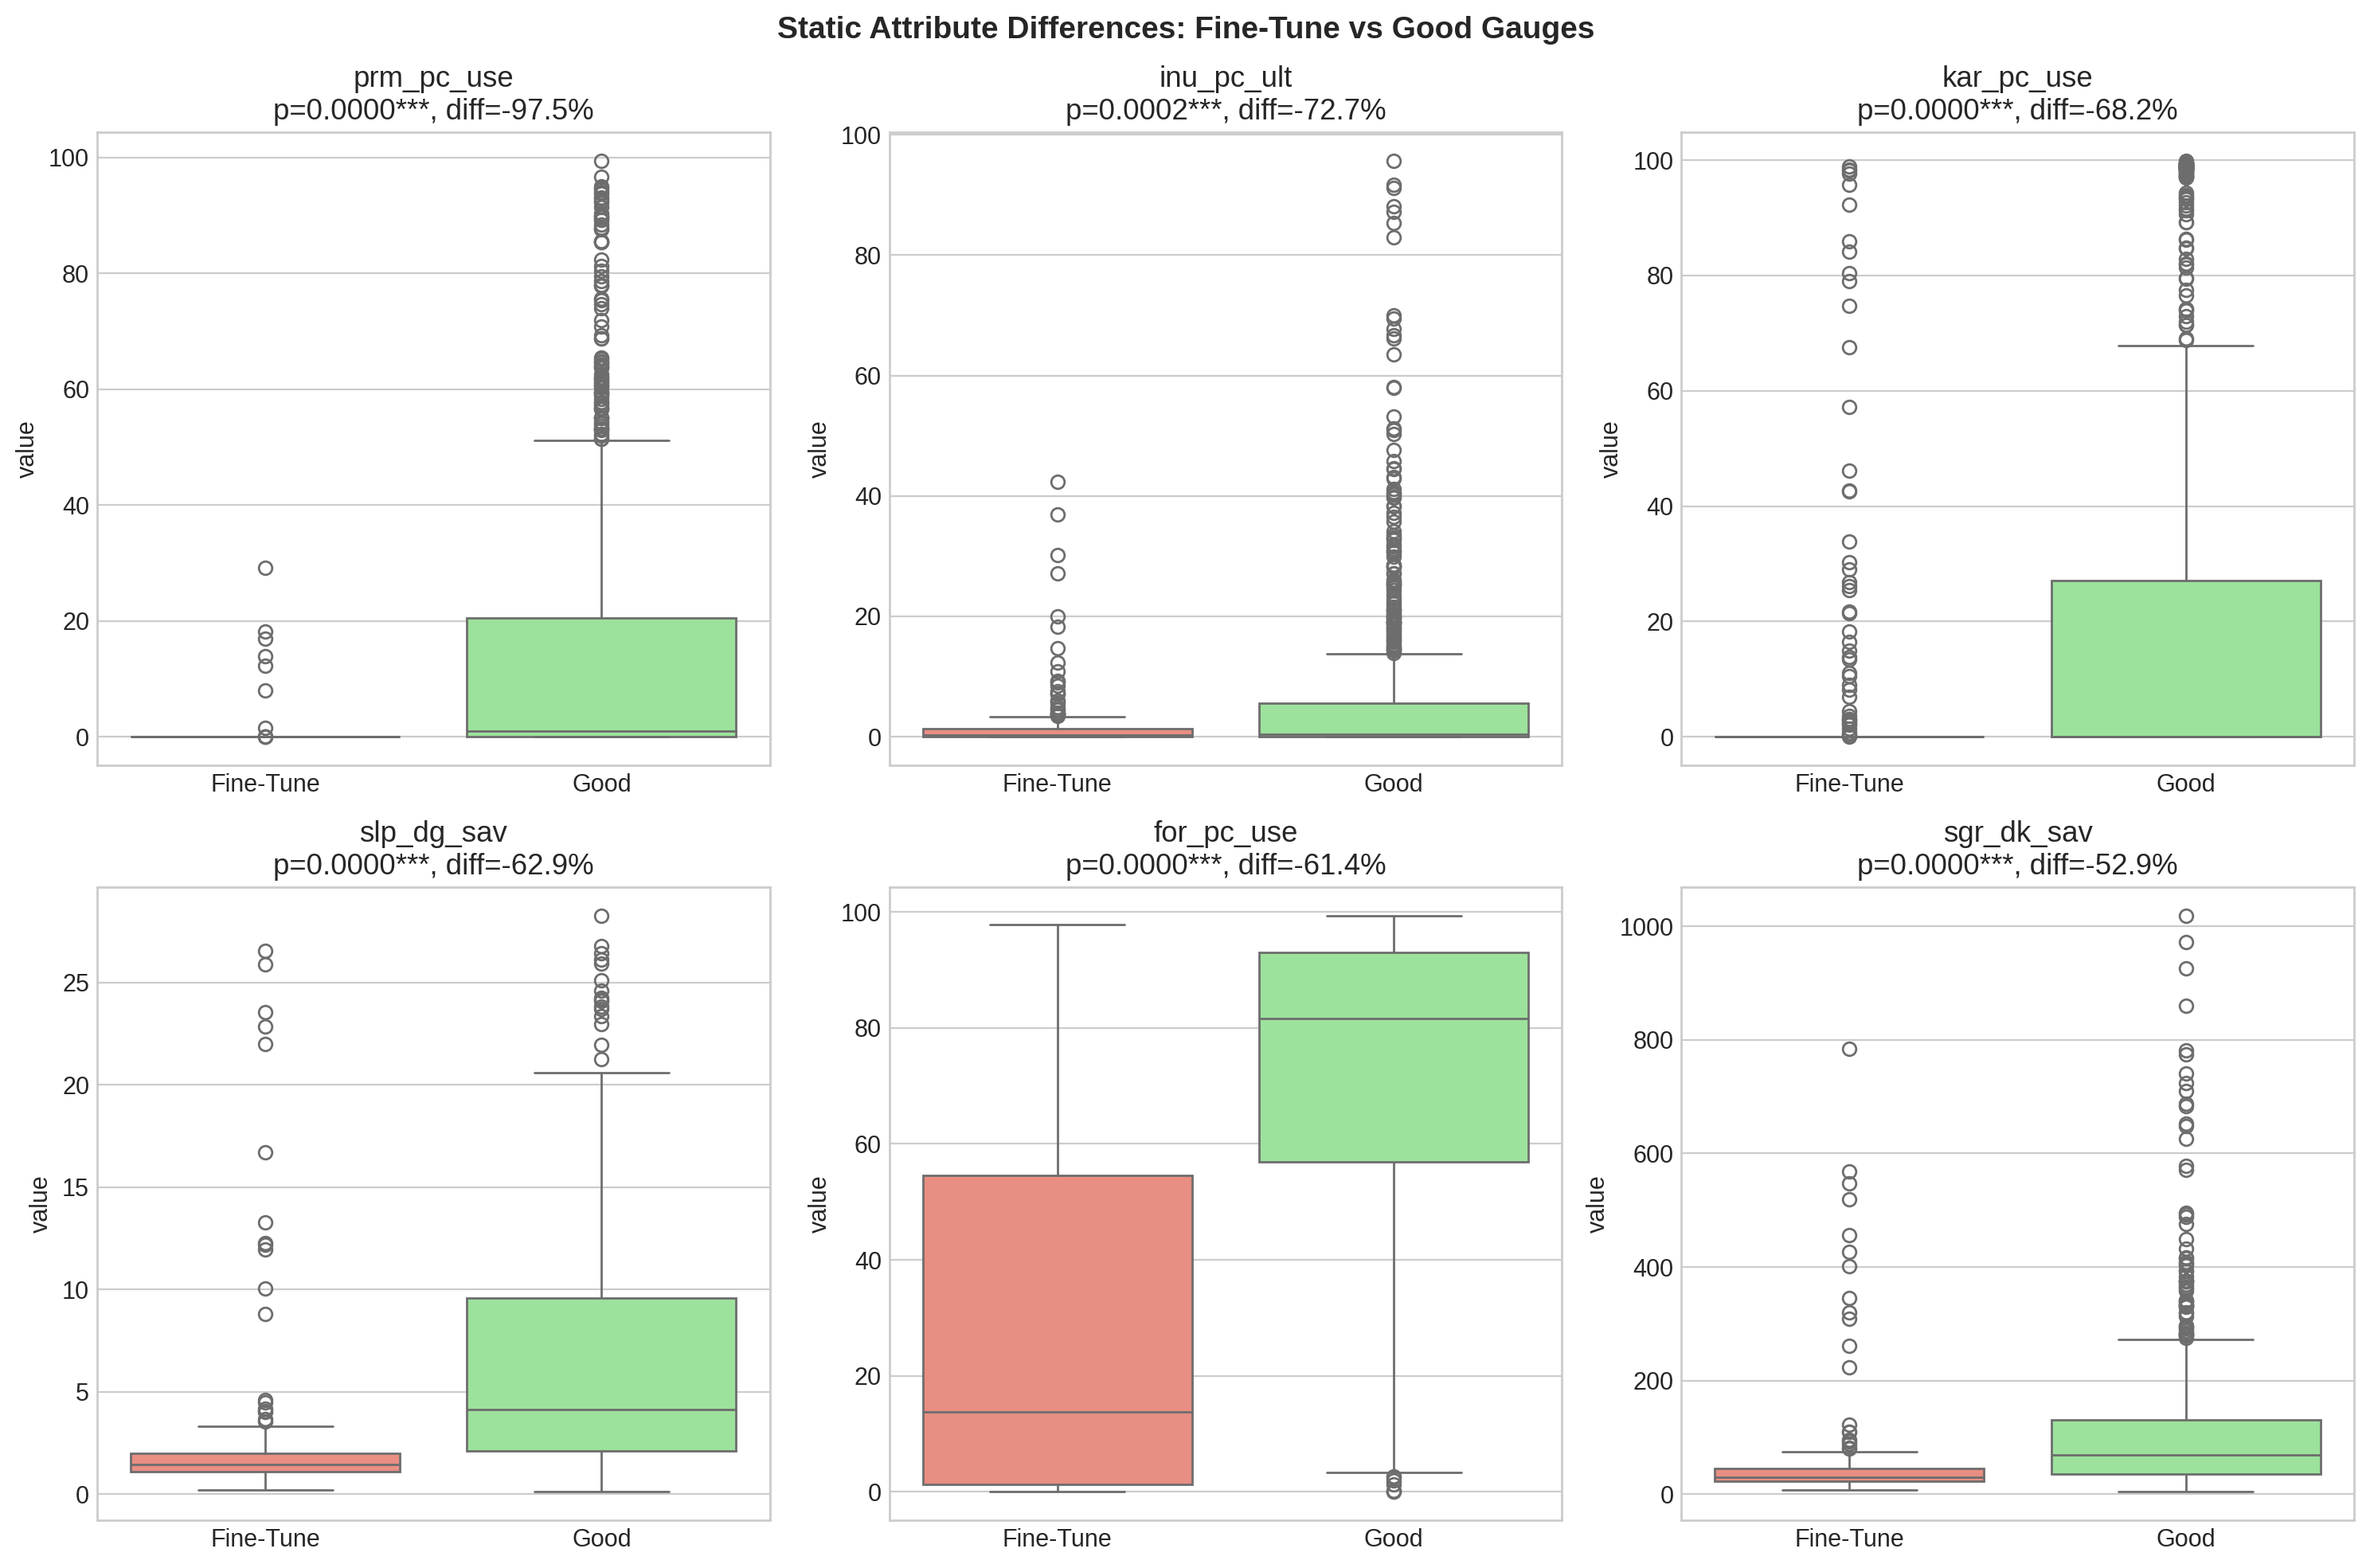

In [ ]:
# Visualize significant attribute differences
sig_attrs = comparison[comparison["p-value"] < 0.05].sort_values("% Diff (FT vs Good)").index.tolist()
if len(sig_attrs) == 0:
    sig_attrs = comparison.sort_values("p-value").head(6).index.tolist()

n_attrs = min(len(sig_attrs), 6)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, attr in zip(axes.flat[:n_attrs], sig_attrs[:n_attrs]):
    ft_vals = ft_attrs[attr].dropna()
    gd_vals = gd_attrs[attr].dropna()

    # Box/violin plot comparison
    data = pd.DataFrame(
        {
            "value": pd.concat([ft_vals, gd_vals]),
            "group": ["Fine-Tune"] * len(ft_vals) + ["Good"] * len(gd_vals),
        }
    )
    sns.boxplot(
        data=data,
        x="group",
        y="value",
        palette={"Fine-Tune": "salmon", "Good": "lightgreen"},
        ax=ax,
    )

    pval = comparison.loc[attr, "p-value"]
    sig = comparison.loc[attr, "significant"]
    diff = comparison.loc[attr, "% Diff (FT vs Good)"]
    ax.set_title(f"{attr}\np={pval:.4f}{sig}, diff={diff:+.1f}%")
    ax.set_xlabel("")

# Hide unused subplots
for ax in axes.flat[n_attrs:]:
    ax.set_visible(False)

plt.suptitle(
    "Static Attribute Differences: Fine-Tune vs Good Gauges",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.savefig(RESULTS_PATH / "comparison_static_attrs.png", dpi=150, bbox_inches="tight")
plt.show()


CLUSTER DISTRIBUTION COMPARISON
Positive % Diff = Over-represented in Fine-Tune gauges


,Fine-Tune Count,Good Count,Fine-Tune %,Good %,% Diff
Cluster_Name,,,,,
Г5,91.0,0.0,34.3,0.0,34.3
Г3,85.0,40.0,32.1,5.5,26.6
Г4,22.0,23.0,8.3,3.1,5.2
Г1,47.0,127.0,17.7,17.4,0.3
Г6,0.0,26.0,0.0,3.6,-3.6
Г2,20.0,105.0,7.5,14.4,-6.9
Г9,0.0,82.0,0.0,11.2,-11.2
Г8,0.0,92.0,0.0,12.6,-12.6
Г7,0.0,113.0,0.0,15.5,-15.5


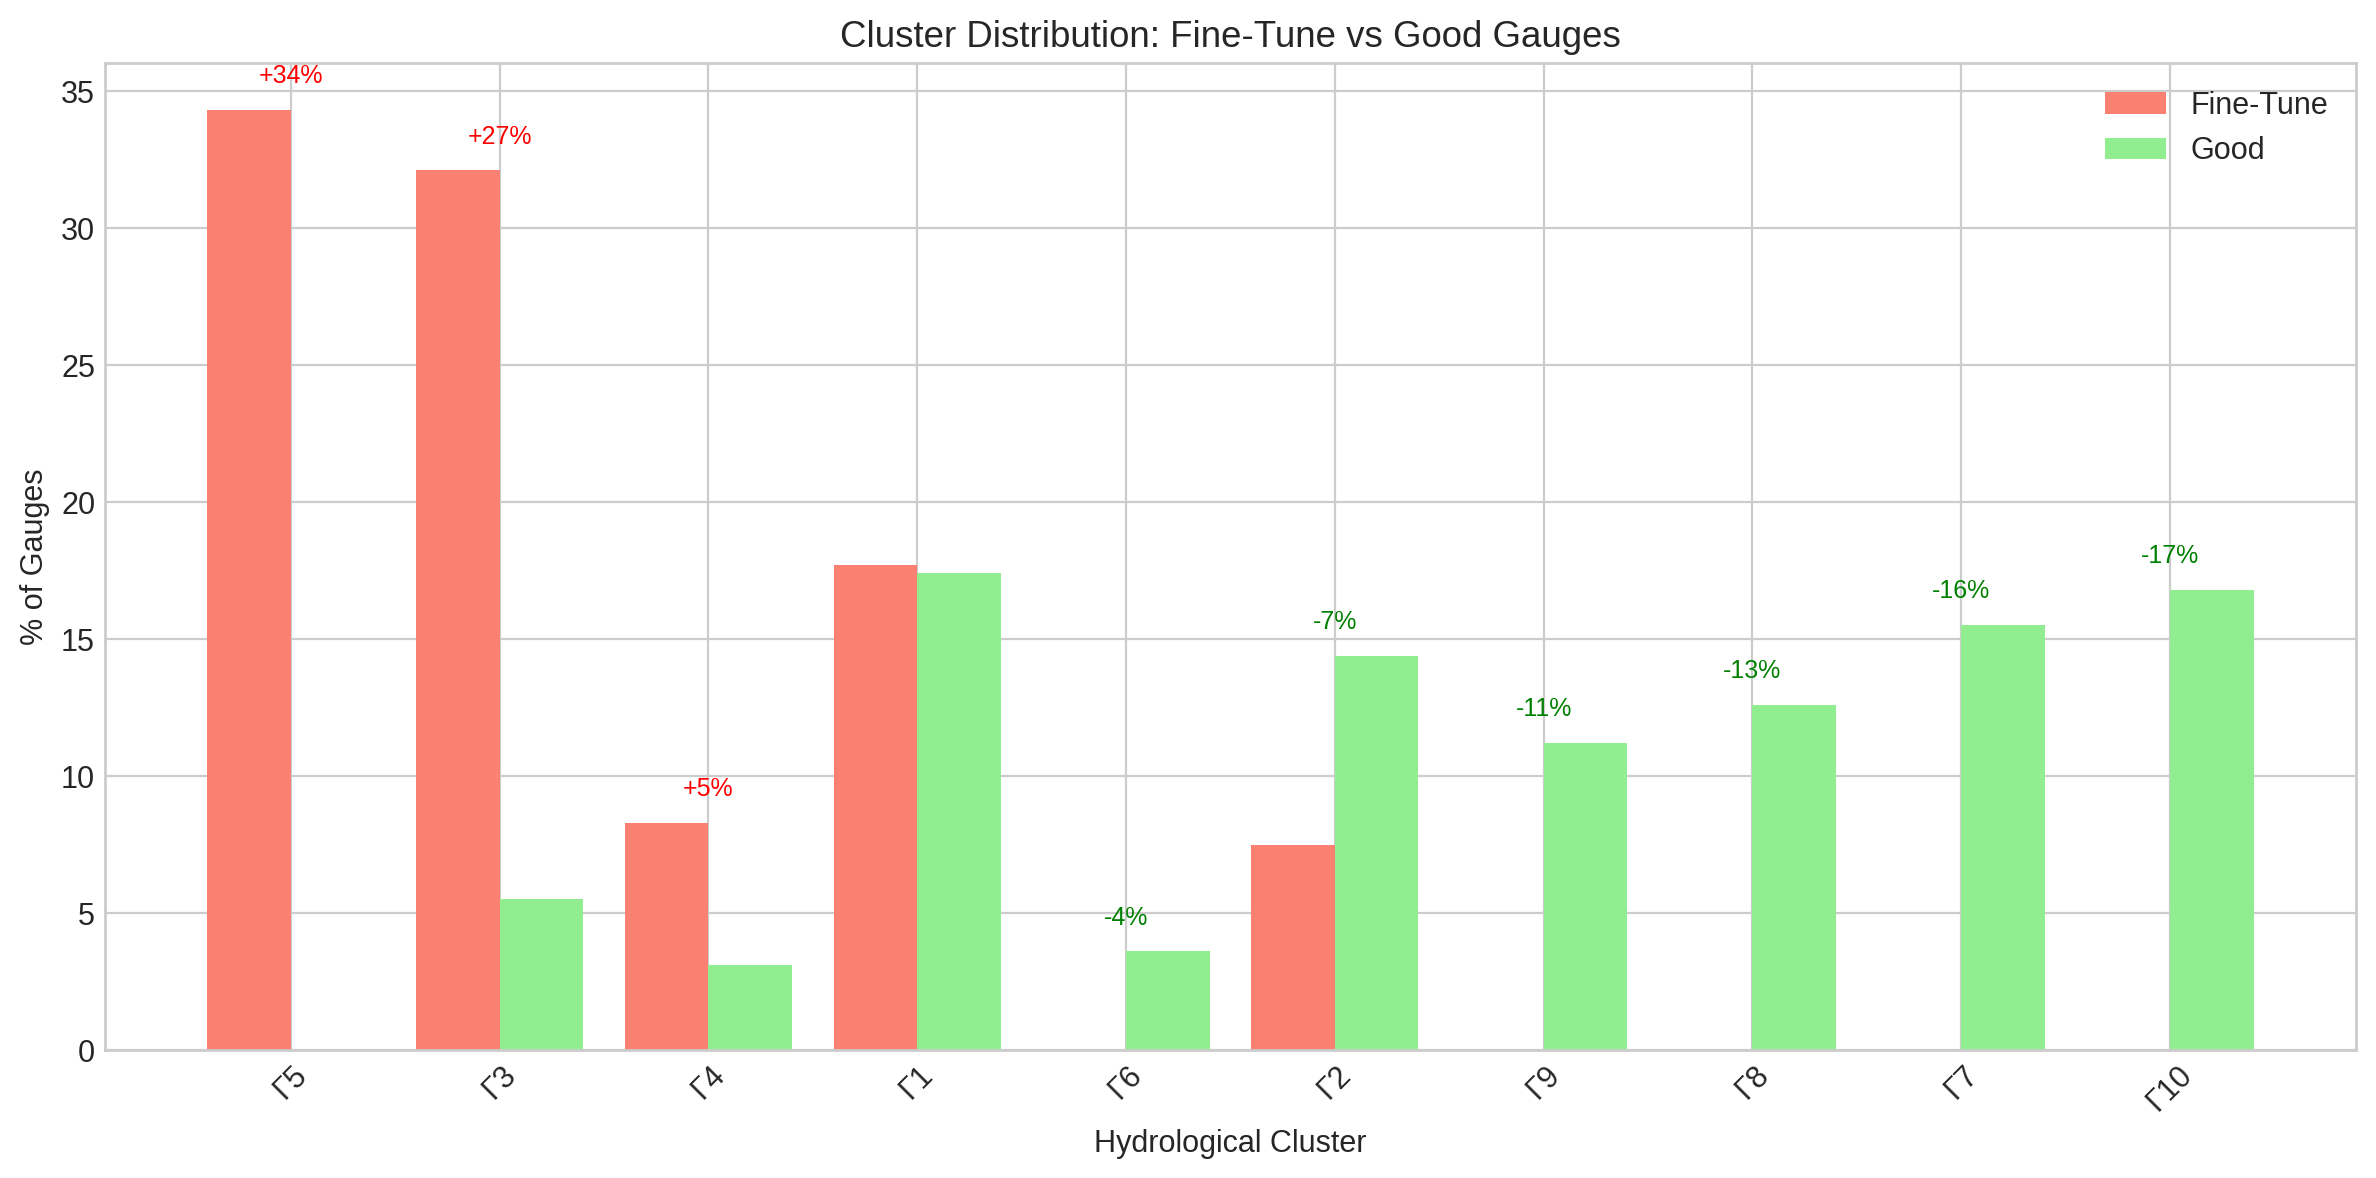

In [ ]:
# Compare cluster distribution between groups
ft_clusters = hydro_clusters.loc[hydro_clusters.index.isin(common_gauges), "Cluster_Name"].value_counts()
gd_clusters = hydro_clusters.loc[hydro_clusters.index.isin(good_gauges), "Cluster_Name"].value_counts()

cluster_comp = pd.DataFrame(
    {
        "Fine-Tune Count": ft_clusters,
        "Good Count": gd_clusters,
        "Fine-Tune %": (ft_clusters / ft_clusters.sum() * 100).round(1),
        "Good %": (gd_clusters / gd_clusters.sum() * 100).round(1),
    }
).fillna(0)
cluster_comp["% Diff"] = (cluster_comp["Fine-Tune %"] - cluster_comp["Good %"]).round(1)
cluster_comp = cluster_comp.sort_values("% Diff", ascending=False)

print("CLUSTER DISTRIBUTION COMPARISON")
print("Positive % Diff = Over-represented in Fine-Tune gauges")
print("=" * 70)
display(cluster_comp)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(cluster_comp))
ax.bar(x - 0.2, cluster_comp["Fine-Tune %"], 0.4, label="Fine-Tune", color="salmon")
ax.bar(x + 0.2, cluster_comp["Good %"], 0.4, label="Good", color="lightgreen")
ax.set_xticks(x)
ax.set_xticklabels(cluster_comp.index, rotation=45)
ax.set(
    xlabel="Hydrological Cluster",
    ylabel="% of Gauges",
    title="Cluster Distribution: Fine-Tune vs Good Gauges",
)
ax.legend()

# Add annotations for big differences
for i, (idx, row) in enumerate(cluster_comp.iterrows()):
    if abs(row["% Diff"]) > 3:
        ax.annotate(
            f"{row['% Diff']:+.0f}%",
            xy=(i, max(row["Fine-Tune %"], row["Good %"]) + 1),
            ha="center",
            fontsize=9,
            color="red" if row["% Diff"] > 0 else "green",
        )

plt.tight_layout()
plt.savefig(RESULTS_PATH / "comparison_cluster_distribution.png", dpi=150, bbox_inches="tight")
plt.show()


Discharge analysis:   0%|          | 0/731 [00:00<?, ?it/s]

DISCHARGE PATTERN COMPARISON
                    Fine-Tune           Good
Mean change:        -22.9%             +5.2%
Std change:         -59.7%            -7.6%
>20% mean drop:     55%                15%


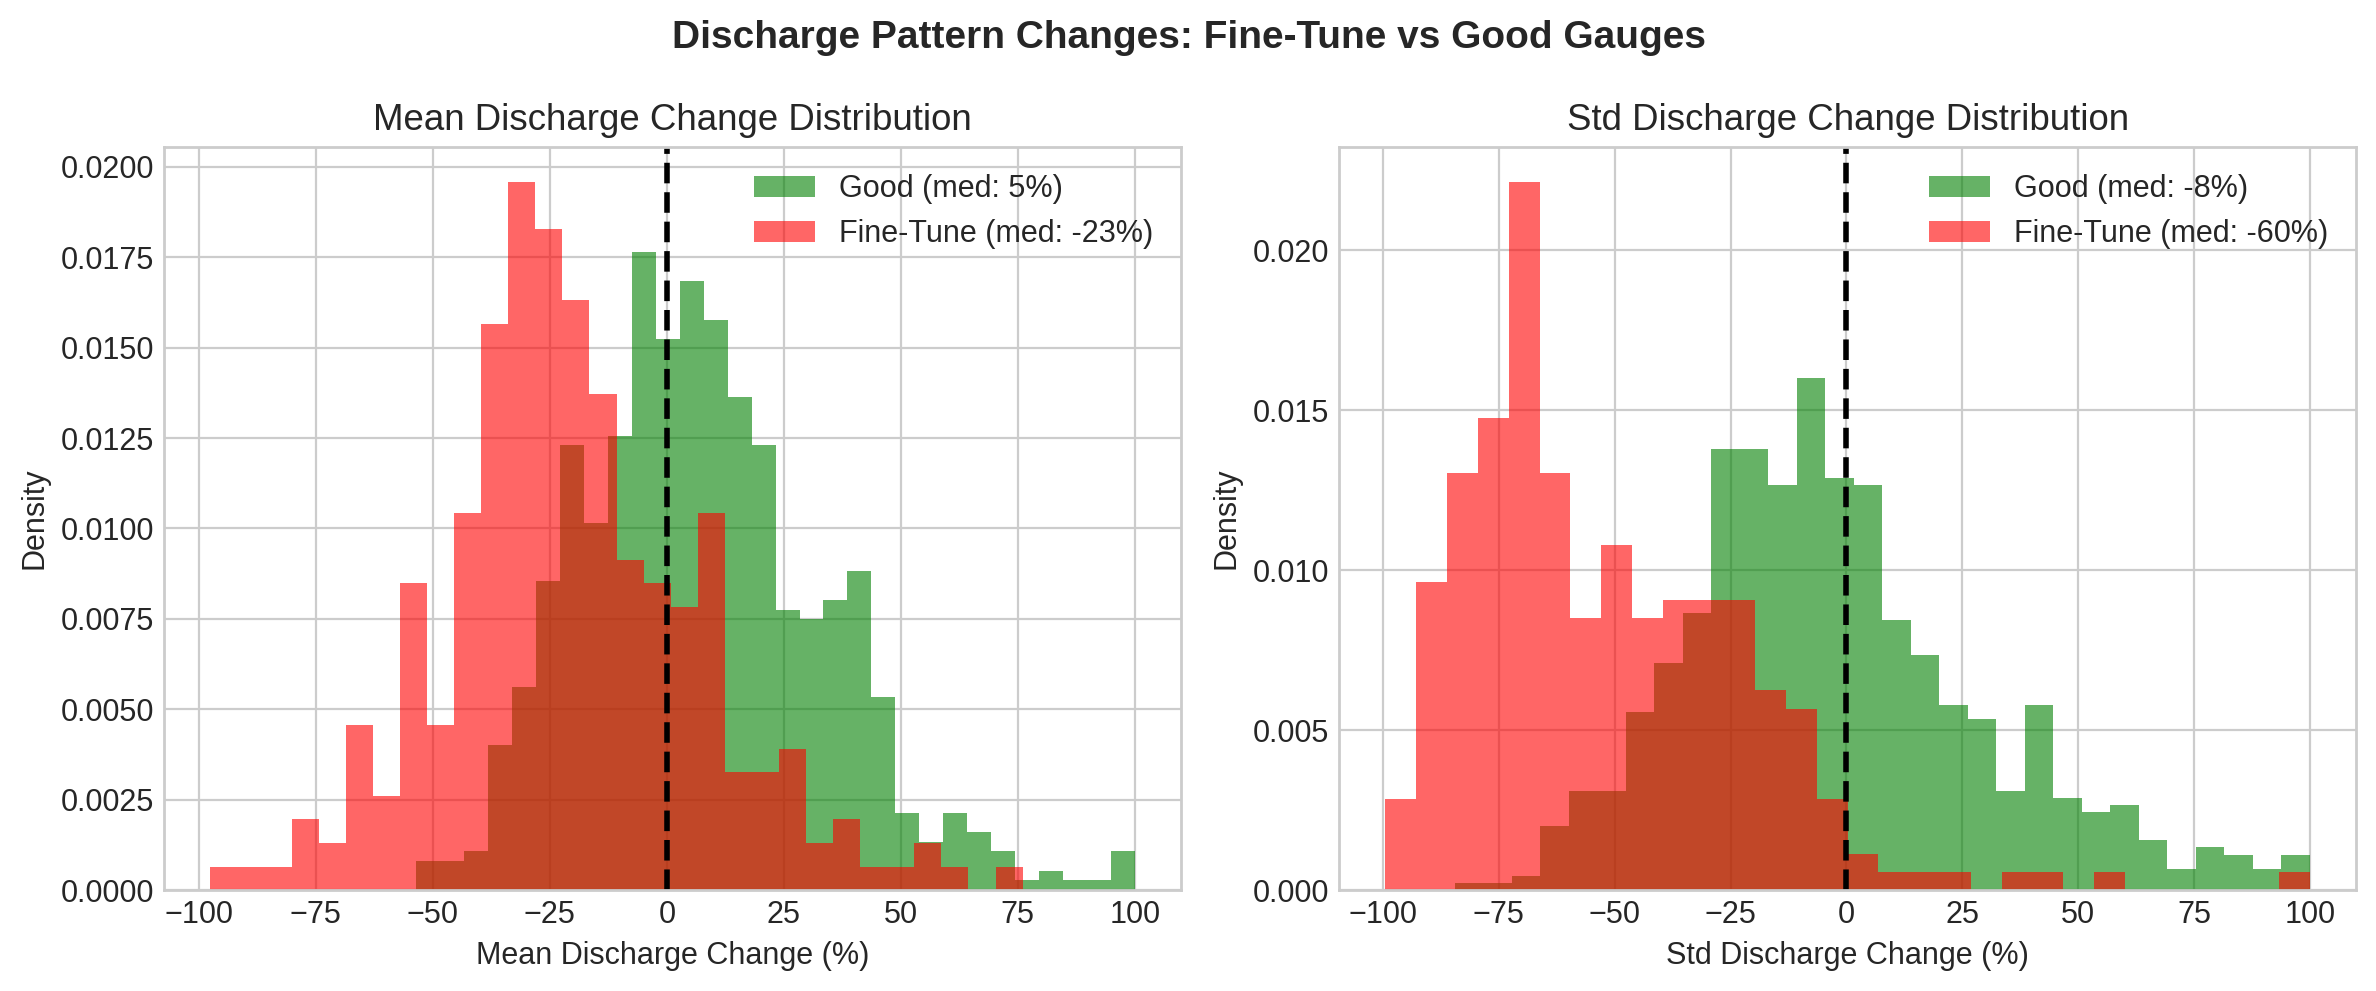

In [ ]:
# Compare discharge patterns between groups
discharge_good = analyze_discharge(model_predictions["lstm"], good_gauges)

print("DISCHARGE PATTERN COMPARISON")
print("=" * 70)
print("                    Fine-Tune           Good")
print(
    f"Mean change:        {discharge['mean_change_pct'].median():+.1f}%             {discharge_good['mean_change_pct'].median():+.1f}%"
)
print(
    f"Std change:         {discharge['std_change_pct'].median():+.1f}%            {discharge_good['std_change_pct'].median():+.1f}%"
)
print(
    f">20% mean drop:     {(discharge['mean_change_pct'] < -20).mean() * 100:.0f}%                {(discharge_good['mean_change_pct'] < -20).mean() * 100:.0f}%"
)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, col, lbl in zip(
    axes, ["mean_change_pct", "std_change_pct"], ["Mean Discharge", "Std Discharge"]
):
    ft_vals = discharge[col].clip(-100, 100)
    gd_vals = discharge_good[col].clip(-100, 100)

    ax.hist(
        gd_vals,
        bins=30,
        alpha=0.6,
        color="green",
        label=f"Good (med: {discharge_good[col].median():.0f}%)",
        density=True,
    )
    ax.hist(
        ft_vals,
        bins=30,
        alpha=0.6,
        color="red",
        label=f"Fine-Tune (med: {discharge[col].median():.0f}%)",
        density=True,
    )
    ax.axvline(0, color="black", ls="--", lw=2)
    ax.set(xlabel=f"{lbl} Change (%)", ylabel="Density", title=f"{lbl} Change Distribution")
    ax.legend()

plt.suptitle("Discharge Pattern Changes: Fine-Tune vs Good Gauges", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(RESULTS_PATH / "comparison_discharge_changes.png", dpi=150, bbox_inches="tight")
plt.show()


In [ ]:
# Final Comparative Summary & Conclusions
print("=" * 80)
print("COMPARATIVE ANALYSIS CONCLUSIONS: WHY DO FINE-TUNE GAUGES FAIL?")
print("=" * 80)

print("\n1. PERFORMANCE GAP")
print("-" * 60)
ft_med = performance_delta["lstm"]["nse_delta"].median()
gd_med = perf_good["lstm"]["nse_delta"].median()
print(f"  LSTM: Fine-tune Δ = {ft_med:.2f}, Good Δ = {gd_med:.2f}")
print(f"  → Fine-tune gauges degrade {abs(ft_med - gd_med):.2f} MORE than good gauges")

print("\n2. CATCHMENT CHARACTERISTICS (Significant Differences)")
print("-" * 60)
sig_attrs_list = comparison[comparison["p-value"] < 0.05].sort_values("p-value")
for attr in sig_attrs_list.head(5).index:
    diff = comparison.loc[attr, "% Diff (FT vs Good)"]
    direction = "higher" if diff > 0 else "lower"
    print(
        f"  {attr}: Fine-tune is {abs(diff):.0f}% {direction} (p={comparison.loc[attr, 'p-value']:.4f})"
    )

print("\n3. HYDROLOGICAL REGIME OVER-REPRESENTATION")
print("-" * 60)
overrep = cluster_comp[cluster_comp["% Diff"] > 3].index.tolist()
underrep = cluster_comp[cluster_comp["% Diff"] < -3].index.tolist()
if overrep:
    print(f"  Over-represented in Fine-Tune: {', '.join(overrep)}")
    for cl in overrep:
        if cl in hydro_cluster_info:
            print(f"    → {cl}: {hydro_cluster_info[cl]['regime_type']}")
if underrep:
    print(f"  Under-represented in Fine-Tune: {', '.join(underrep)}")

print("\n4. CLIMATE SENSITIVITY")
print("-" * 60)
ft_drop = (discharge["mean_change_pct"] < -20).mean() * 100
gd_drop = (discharge_good["mean_change_pct"] < -20).mean() * 100
print(f"  Gauges with >20% discharge drop: {ft_drop:.0f}% (Fine-Tune) vs {gd_drop:.0f}% (Good)")
print("  → Fine-tune gauges experience MORE severe climate shifts")

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print("""
Fine-tune gauges fail because they are fundamentally DIFFERENT catchments:

1. GEOGRAPHY: Higher elevation, more cropland, less forest cover
2. HYDROLOGY: Over-represented in spring flood (весеннее половодье) regimes
3. CLIMATE: Experience more severe discharge reductions (drought conditions)
4. COMPLEXITY: Likely have more complex rainfall-runoff relationships

These gauges require:
- Domain-specific fine-tuning (transfer learning)
- Additional input features (snowpack, soil moisture)
- Possibly different model architectures for ephemeral/intermittent flow
""")


COMPARATIVE ANALYSIS CONCLUSIONS: WHY DO FINE-TUNE GAUGES FAIL?

1. PERFORMANCE GAP
------------------------------------------------------------
  LSTM: Fine-tune Δ = -0.54, Good Δ = -0.12
  → Fine-tune gauges degrade 0.42 MORE than good gauges

2. CATCHMENT CHARACTERISTICS (Significant Differences)
------------------------------------------------------------
  crp_pc_use: Fine-tune is 595% higher (p=0.0000)
  pst_pc_use: Fine-tune is 303% higher (p=0.0000)
  for_pc_use: Fine-tune is 61% lower (p=0.0000)
  prm_pc_use: Fine-tune is 98% lower (p=0.0000)
  cly_pc_uav: Fine-tune is 44% higher (p=0.0000)

3. HYDROLOGICAL REGIME OVER-REPRESENTATION
------------------------------------------------------------
  Over-represented in Fine-Tune: Г5, Г3, Г4
    → Г5: Весеннее половодье (паводочный)
    → Г3: Весеннее половодье (паводочный)
    → Г4: Летнее половодье (паводочный)
  Under-represented in Fine-Tune: Г6, Г2, Г9, Г8, Г7, Г10

4. CLIMATE SENSITIVITY
--------------------------------------

In [ ]:
# Save comparison results
comparison.to_csv(RESULTS_PATH / "comparison_static_attrs.csv")
cluster_comp.to_csv(RESULTS_PATH / "comparison_cluster_distribution.csv")

# Save good gauge metrics for reference
gd_metrics = pd.DataFrame(index=good_gauges)
for m in MODELS:
    gd_metrics[f"{m}_nse_train"] = perf_good[m].loc[perf_good[m].index.isin(good_gauges), "nse_train"]
    gd_metrics[f"{m}_nse_test"] = perf_good[m].loc[perf_good[m].index.isin(good_gauges), "nse_test"]
    gd_metrics[f"{m}_nse_delta"] = perf_good[m].loc[perf_good[m].index.isin(good_gauges), "nse_delta"]
gd_metrics["hydro_cluster"] = hydro_clusters.loc[hydro_clusters.index.isin(good_gauges), "Cluster_Name"]
gd_metrics.to_csv(RESULTS_PATH / "good_gauges_metrics.csv")

print(f"\nComparison results saved to {RESULTS_PATH}:")
print("  - comparison_static_attrs.csv")
print("  - comparison_cluster_distribution.csv")
print("  - good_gauges_metrics.csv")
print("  - comparison_*.png visualizations")



Comparison results saved to ../res/chapter_two:
  - comparison_static_attrs.csv
  - comparison_cluster_distribution.csv
  - good_gauges_metrics.csv
  - comparison_*.png visualizations


---
# Hybrid Cluster Analysis

Analyzing fine-tune gauges through **hybrid classification** (geographic + hydrological) to understand complex interactions.


In [ ]:
# Load hybrid cluster data
hybrid_mapping = pd.read_csv(CHAPTER_ONE_PATH / "gauge_hybrid_mapping.csv", dtype={"gauge_id": str})
hybrid_mapping.set_index("gauge_id", inplace=True)

with open(CHAPTER_ONE_PATH / "hybrid_cluster_descriptions.json") as f:
    hybrid_info = {c["hybrid_id"]: c for c in json.load(f)}

print(f"Loaded {len(hybrid_mapping)} gauges with hybrid classification")
print(f"Hybrid classes: {len(hybrid_info)}")
print(f"\nHybrid classes available: {list(hybrid_info.keys())[:10]}...")

# Map hybrid to fine-tune gauges
ft_hybrid = hybrid_mapping.loc[hybrid_mapping.index.isin(common_gauges), "hybrid_class"].value_counts()
gd_hybrid = hybrid_mapping.loc[hybrid_mapping.index.isin(good_gauges), "hybrid_class"].value_counts()

print(f"\nFine-tune gauges with hybrid mapping: {ft_hybrid.sum()}")
print(f"Good gauges with hybrid mapping: {gd_hybrid.sum()}")


Loaded 996 gauges with hybrid classification
Hybrid classes: 16

Hybrid classes available: ['Ф4-Г8', 'Ф10-Г3', 'Ф9-Г7', 'Ф1-Г5', 'Ф8-Г2', 'Ф7-Г1', 'Ф5-Г2', 'Ф2-Mixed', 'Ф10-Г1', 'Ф6-Г10']...

Fine-tune gauges with hybrid mapping: 265
Good gauges with hybrid mapping: 731


In [ ]:
# Add hybrid cluster to analysis dataframe
df = analysis_dfs["lstm"].copy()
df["hybrid_class"] = hybrid_mapping.loc[df.index.intersection(hybrid_mapping.index), "hybrid_class"]
df["geo_cluster"] = hybrid_mapping.loc[df.index.intersection(hybrid_mapping.index), "geo_cluster_ru"]

# Performance by hybrid cluster
hybrid_stats = (
    df.groupby("hybrid_class")
    .agg(
        {
            "nse_train": ["mean", "count"],
            "nse_test": ["mean"],
            "nse_delta": ["mean", "median", "std"],
        }
    )
    .round(3)
)
hybrid_stats.columns = ["_".join(c) for c in hybrid_stats.columns]
hybrid_stats["pct_degraded"] = df.groupby("hybrid_class").apply(
    lambda x: (x["nse_delta"] < 0).mean() * 100
)
hybrid_stats = hybrid_stats.sort_values("nse_delta_mean")

print("FINE-TUNE GAUGES: Performance by Hybrid Class")
print("Sorted by worst mean NSE delta")
print("=" * 80)
display(hybrid_stats.head(10))


FINE-TUNE GAUGES: Performance by Hybrid Class
Sorted by worst mean NSE delta


,nse_train_mean,nse_train_count,nse_test_mean,nse_delta_mean,nse_delta_median,nse_delta_std,pct_degraded
hybrid_class,,,,,,,
Ф1-Г1,0.675,30,-148.059,-148.734,-1.982,749.299,93.333333
Ф1-Г3,0.635,32,-1.768,-2.403,-1.059,3.257,90.625000
Ф1-Г5,0.556,70,-1.774,-2.330,-0.555,10.097,95.714286
Ф3-Г4,0.596,9,-1.498,-2.094,-0.443,3.429,100.000000
Ф2-Mixed,0.644,39,-0.987,-1.631,-0.421,3.706,87.179487
Ф10-Г3,0.765,44,-0.252,-1.016,-0.513,1.487,97.727273
Ф7-Г1,0.737,11,-0.065,-0.802,-0.389,0.917,100.000000
Ф10-Г1,0.815,4,0.275,-0.540,-0.509,0.266,100.000000
Ф8-Г2,0.859,3,0.393,-0.466,-0.426,0.164,100.000000


In [ ]:
# Show descriptions for worst hybrid clusters
worst_hybrids = hybrid_stats.head(5).index.tolist()

print("=" * 80)
print("WORST PERFORMING HYBRID CLASSES - DETAILED DESCRIPTIONS")
print("=" * 80)

for hc in worst_hybrids:
    n_gauges = hybrid_stats.loc[hc, "nse_train_count"]
    delta_mean = hybrid_stats.loc[hc, "nse_delta_mean"]
    pct_deg = hybrid_stats.loc[hc, "pct_degraded"]

    print(f"\n{'=' * 60}")
    print(f"🔴 {hc}: {int(n_gauges)} gauges, Mean Δ={delta_mean:.2f}, {pct_deg:.0f}% degraded")
    print(f"{'=' * 60}")

    if hc in hybrid_info:
        info = hybrid_info[hc]
        # Parse key info from description
        desc = info["description"]
        print(f"\n{desc[:1000]}...")
    else:
        print("  (No detailed description available)")


WORST PERFORMING HYBRID CLASSES - DETAILED DESCRIPTIONS

🔴 Ф1-Г1: 30 gauges, Mean Δ=-148.73, 93% degraded

**Ф1-Г1**: This hybrid class combines clay-rich (19.7%) landscape characteristics with cluster 1 hydrological patterns. Geographically, Cluster 1 encompasses 152 catchments characterized by moderate elevation (221 m) with gentle slopes (1.7°). Limited forest cover (8%) characterizes the area, with substantial agricultural land use (56% cropland). Mixed soil texture (clay: 20%, silt: 44%, sand: 35%) provides intermediate infiltration characteristics. Inundation-prone areas (1.2%) offer flood storage capacity and wetland ecosystems. Deep groundwater tables (1.8 m) limit groundwater-surface water exchange.  Hydrologically, Cluster Г1 represents catchments characterized by moderate annual precipitation (539 mm/year) and moderate temperatures (2.2°C). Baseflow contributes 52.4% of total discharge, indicating moderate groundwater influence. High flow variability indicates flashy hydrolo

HYBRID CLUSTER DISTRIBUTION: Fine-Tune vs Good Gauges
Positive % Diff = Over-represented in Fine-Tune gauges


,Fine-Tune Count,Good Count,Fine-Tune %,Good %,% Diff
hybrid_class,,,,,
Ф1-Г5,70.0,11,26.4,1.5,24.9
Ф2-Mixed,39.0,15,14.7,2.1,12.6
Ф1-Г3,32.0,3,12.1,0.4,11.7
Ф1-Г1,30.0,6,11.3,0.8,10.5
Ф10-Г3,44.0,75,16.6,10.3,6.3
Ф7-Г2,14.0,10,5.3,1.4,3.9
Ф3-Г4,9.0,22,3.4,3.0,0.4
Ф10-Г1,4.0,36,1.5,4.9,-3.4
Ф10-Г10,0.0,25,0.0,3.4,-3.4


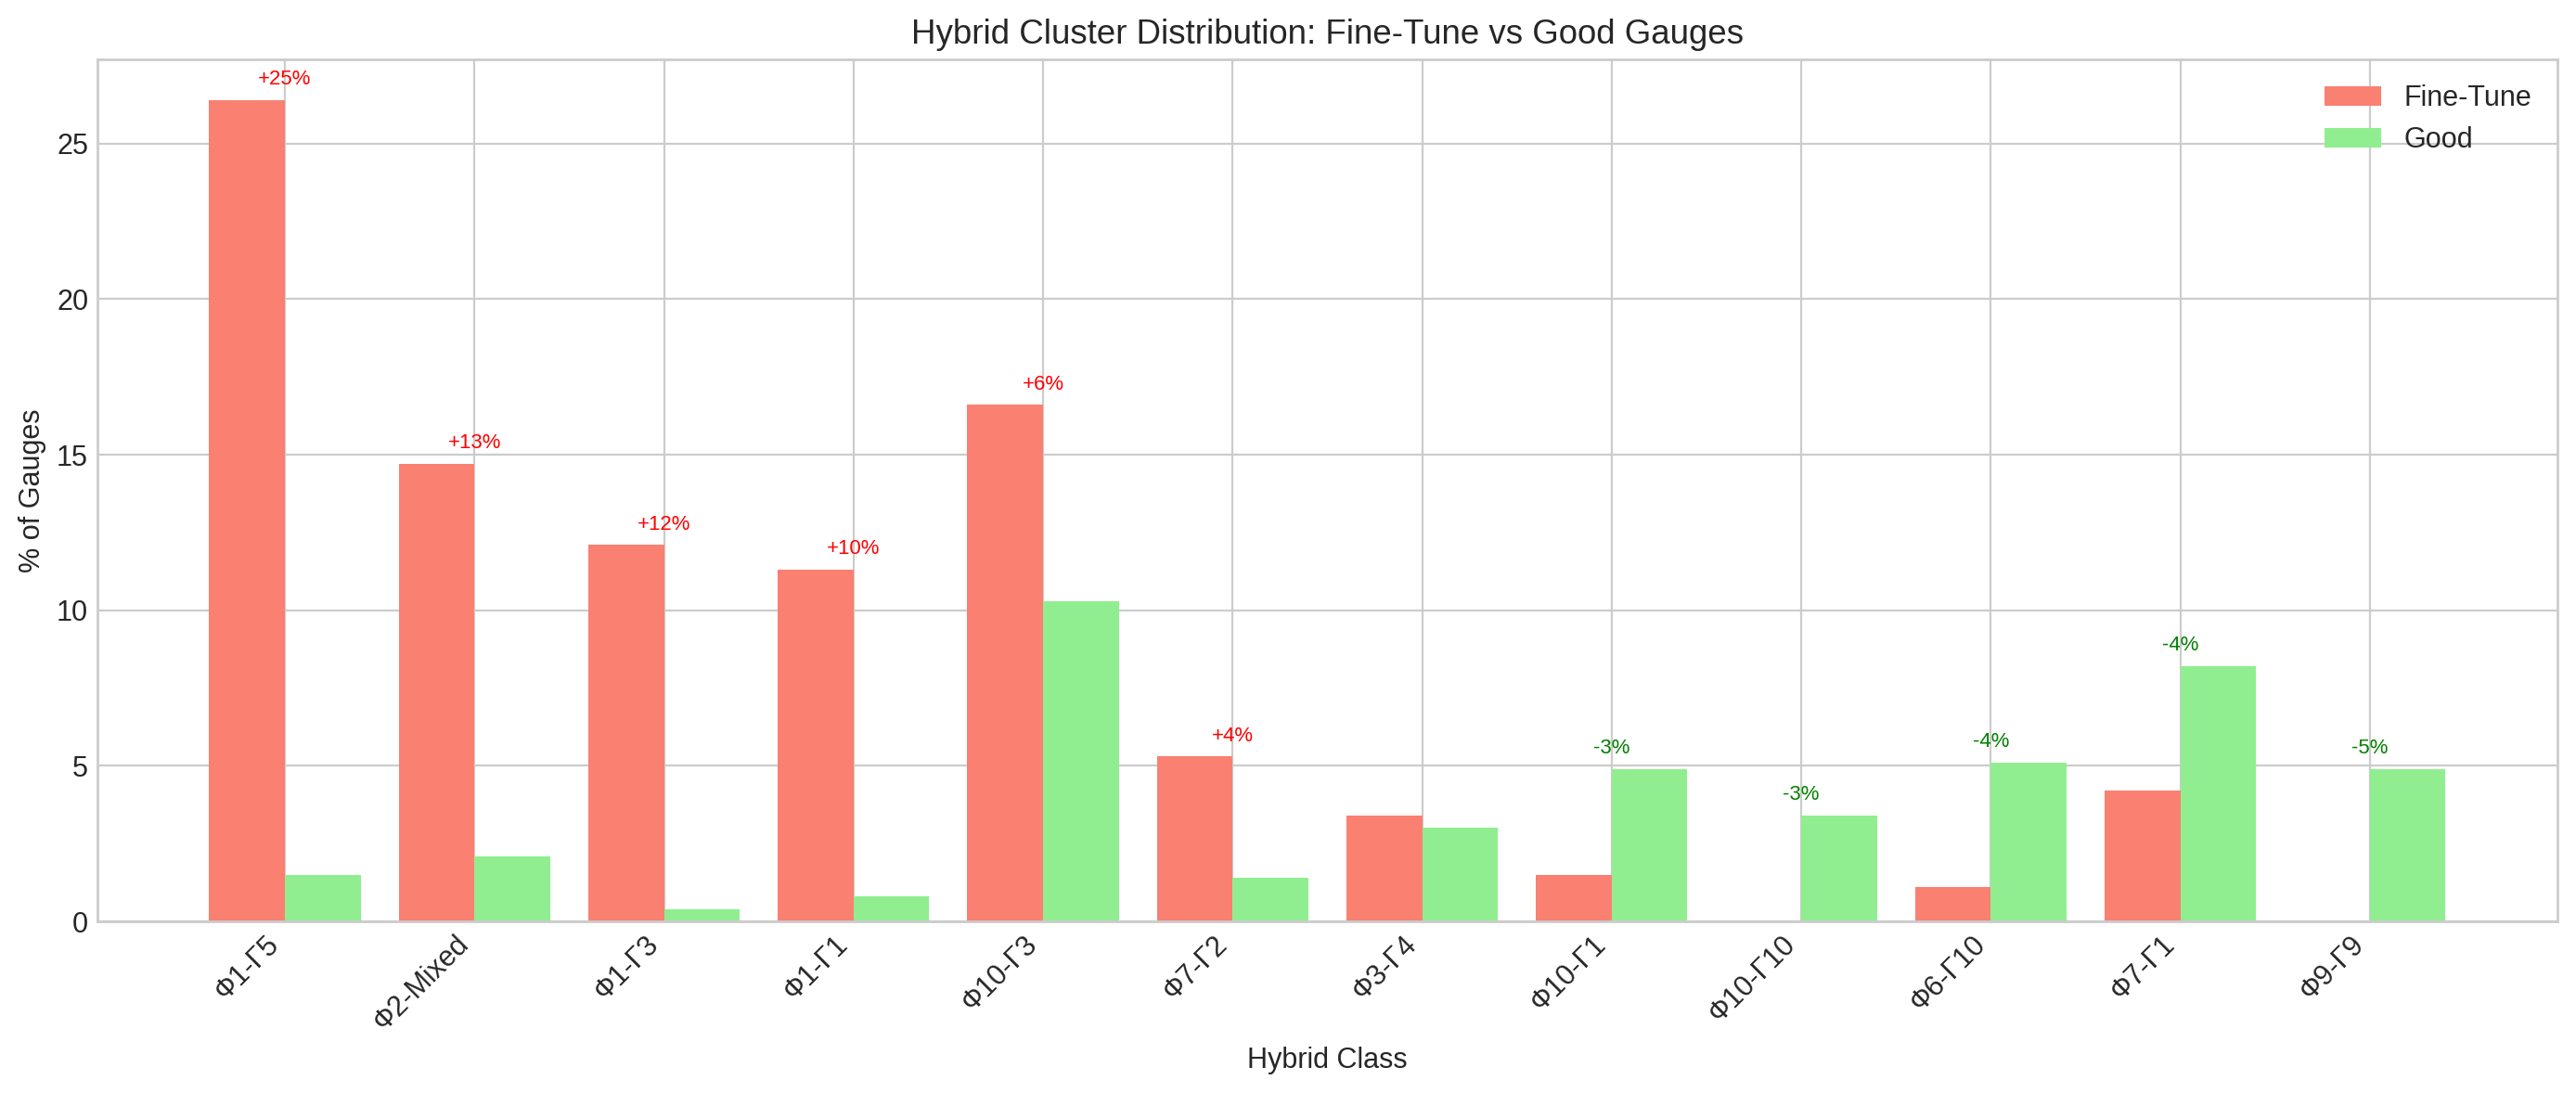

In [ ]:
# Compare hybrid cluster distribution: Fine-tune vs Good gauges
hybrid_comp = pd.DataFrame(
    {
        "Fine-Tune Count": ft_hybrid,
        "Good Count": gd_hybrid,
        "Fine-Tune %": (ft_hybrid / ft_hybrid.sum() * 100).round(1),
        "Good %": (gd_hybrid / gd_hybrid.sum() * 100).round(1),
    }
).fillna(0)
hybrid_comp["% Diff"] = (hybrid_comp["Fine-Tune %"] - hybrid_comp["Good %"]).round(1)
hybrid_comp = hybrid_comp.sort_values("% Diff", ascending=False)

print("HYBRID CLUSTER DISTRIBUTION: Fine-Tune vs Good Gauges")
print("Positive % Diff = Over-represented in Fine-Tune gauges")
print("=" * 80)
display(hybrid_comp.head(10))

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))
top_hybrids = hybrid_comp.head(12).index
x = np.arange(len(top_hybrids))
ax.bar(
    x - 0.2,
    hybrid_comp.loc[top_hybrids, "Fine-Tune %"],
    0.4,
    label="Fine-Tune",
    color="salmon",
)
ax.bar(x + 0.2, hybrid_comp.loc[top_hybrids, "Good %"], 0.4, label="Good", color="lightgreen")
ax.set_xticks(x)
ax.set_xticklabels(top_hybrids, rotation=45, ha="right")
ax.set(
    xlabel="Hybrid Class",
    ylabel="% of Gauges",
    title="Hybrid Cluster Distribution: Fine-Tune vs Good Gauges",
)
ax.legend()

# Annotate differences
for i, hc in enumerate(top_hybrids):
    diff = hybrid_comp.loc[hc, "% Diff"]
    if abs(diff) > 2:
        y_pos = float(max(hybrid_comp.loc[hc, "Fine-Tune %"], hybrid_comp.loc[hc, "Good %"])) + 0.5
        ax.annotate(
            f"{diff:+.0f}%",
            xy=(i, y_pos),
            ha="center",
            fontsize=8,
            color="red" if diff > 0 else "green",
        )

plt.tight_layout()
plt.savefig(RESULTS_PATH / "hybrid_cluster_distribution.png", dpi=150, bbox_inches="tight")
plt.show()


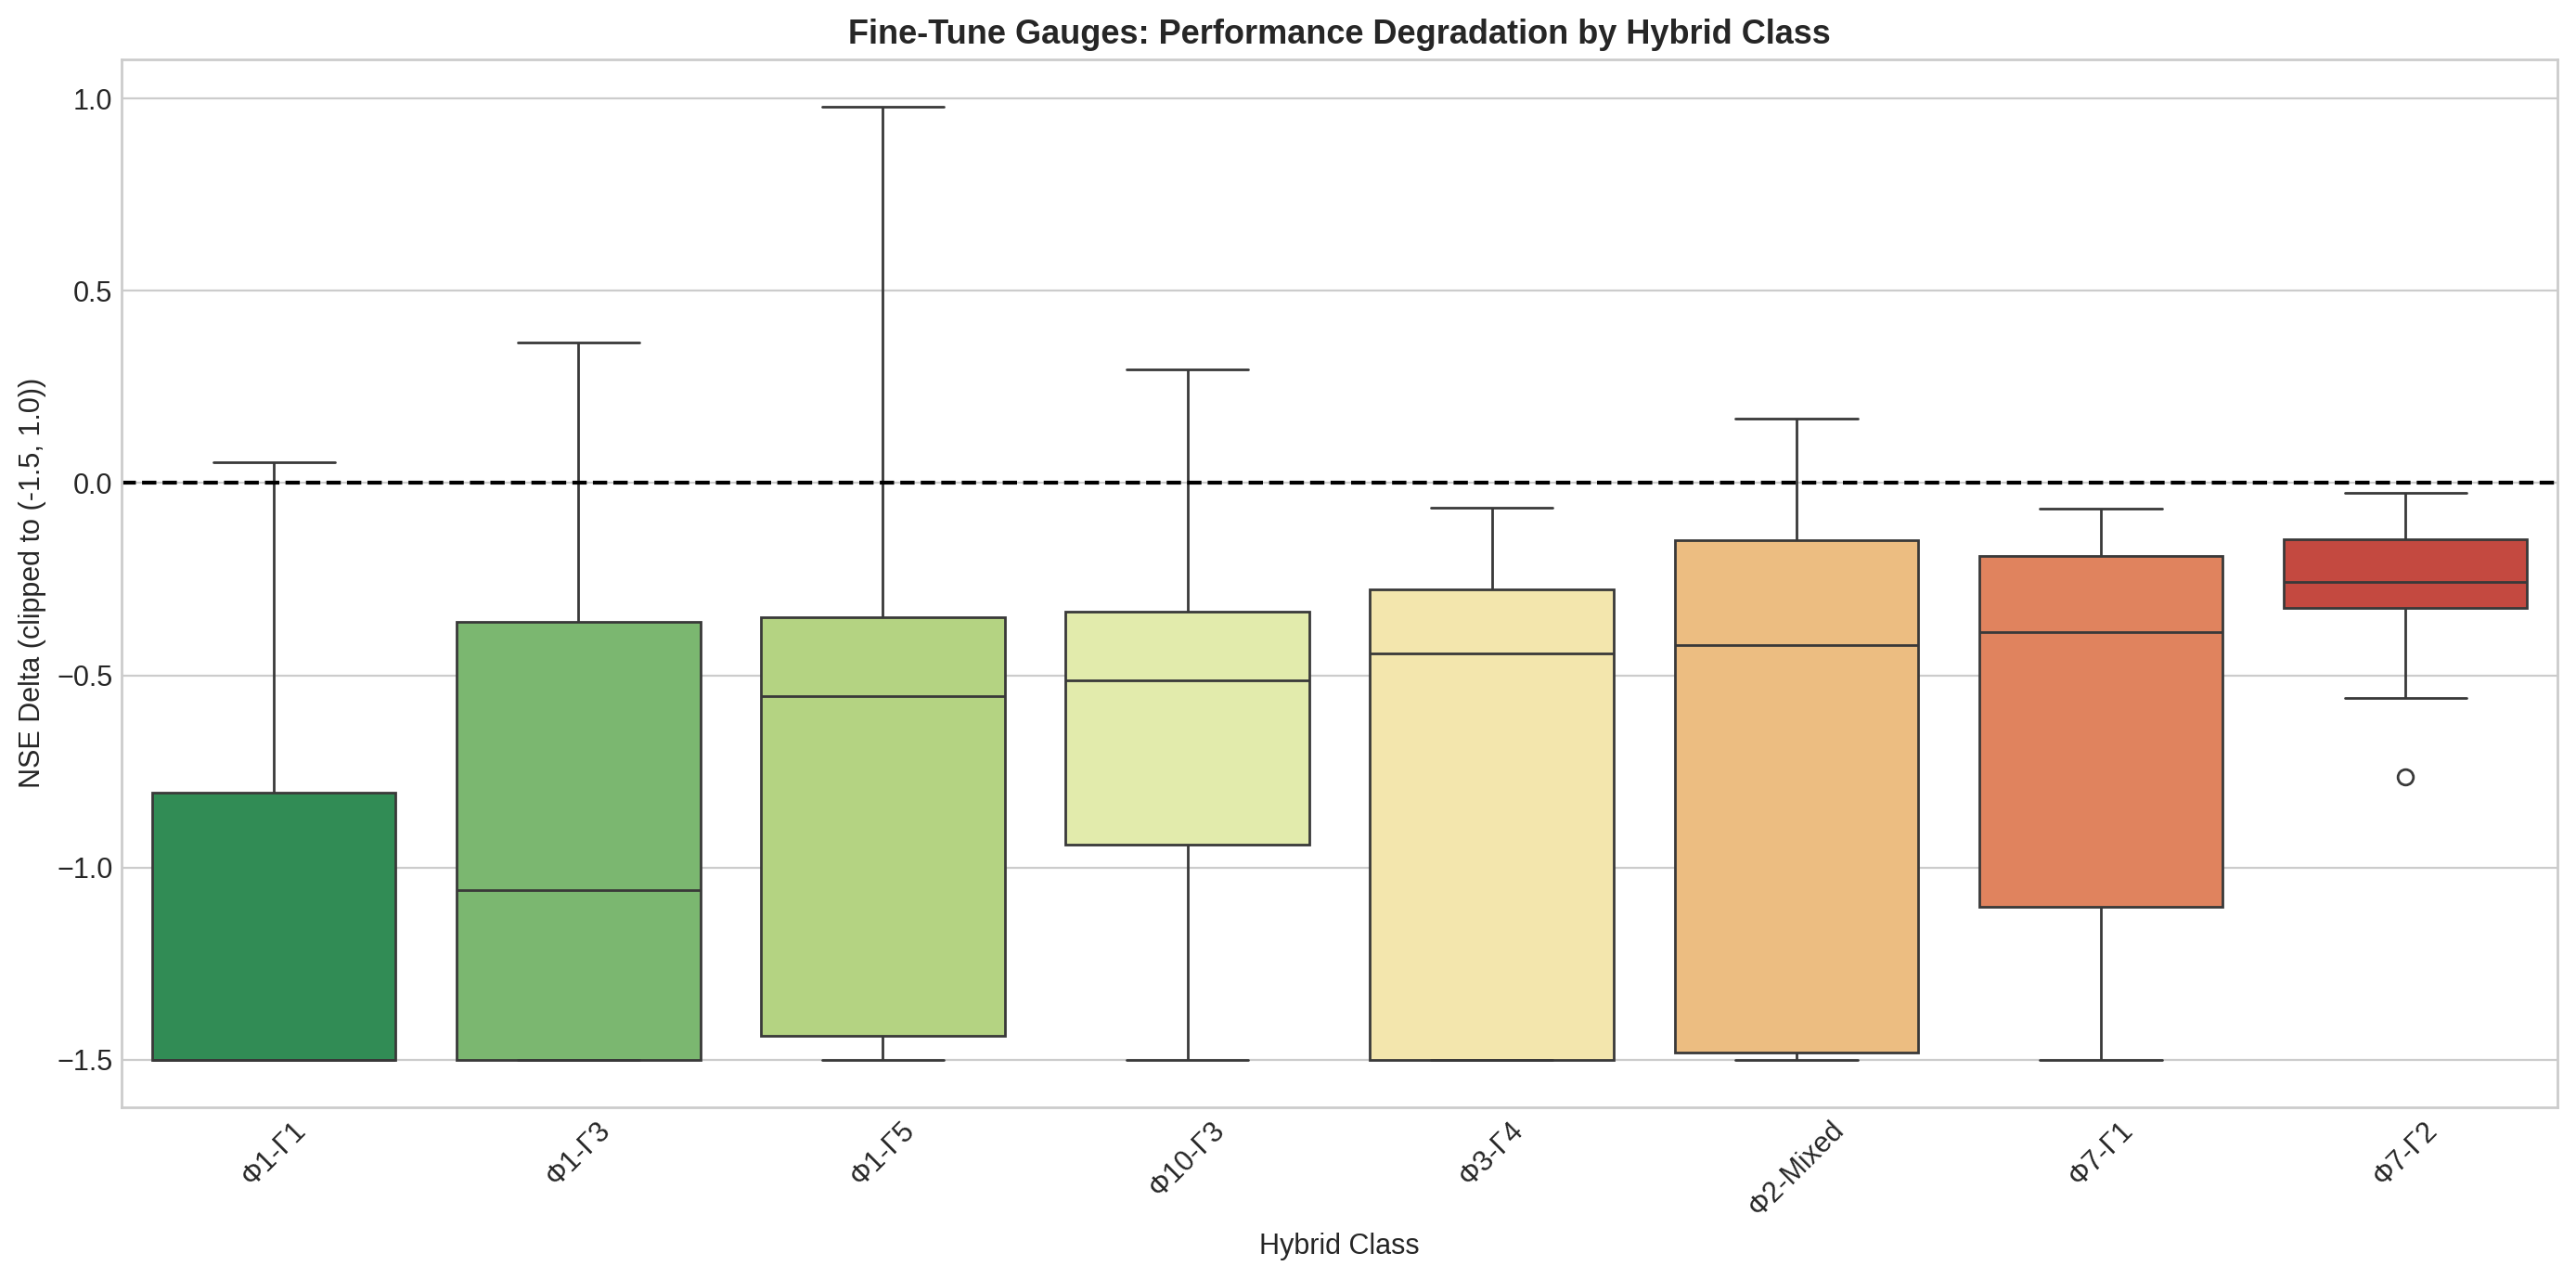

In [23]:
# Performance boxplot by hybrid cluster (for fine-tune gauges)
# Filter to clusters with at least 5 gauges
valid_hybrids = hybrid_stats[hybrid_stats["nse_train_count"] >= 5].index.tolist()
df_plot = df[df["hybrid_class"].isin(valid_hybrids)].copy()

# Order by median delta
order = df_plot.groupby("hybrid_class")["nse_delta"].median().sort_values().index

fig, ax = plt.subplots(figsize=(14, 7))
sns.boxplot(
    data=df_plot,
    x="hybrid_class",
    y="nse_delta_clip",
    order=order,
    palette="RdYlGn_r",
    ax=ax,
)
ax.axhline(0, color="black", ls="--", lw=1.5)
ax.set_xlabel("Hybrid Class", fontsize=11)
ax.set_ylabel(f"NSE Delta (clipped to {DELTA_CLIP})", fontsize=11)
ax.set_title(
    "Fine-Tune Gauges: Performance Degradation by Hybrid Class",
    fontsize=13,
    fontweight="bold",
)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(RESULTS_PATH / "hybrid_performance_boxplot.png", dpi=150, bbox_inches="tight")
plt.show()


In [24]:
# Extract key characteristics from hybrid cluster descriptions
def extract_key_traits(hybrid_id):
    if hybrid_id not in hybrid_info:
        return {"geo": "Unknown", "hydro": "Unknown", "key_feature": "Unknown"}

    info = hybrid_info[hybrid_id]
    desc = info["description"]

    # Extract key landscape features
    features = []
    if "karst" in desc.lower():
        features.append("karst")
    if "permafrost" in desc.lower():
        features.append("permafrost")
    if "cropland" in desc.lower() and ("56%" in desc or "42%" in desc):
        features.append("high cropland")
    if "forest" in desc.lower() and "92%" in desc:
        features.append("dense forest")
    if "lake" in desc.lower():
        features.append("lake-regulated")
    if "clay" in desc.lower() and "20%" in desc:
        features.append("clay-rich")
    if "elevation" in desc.lower() and ("1033" in desc or "2021" in desc):
        features.append("high elevation")
    if "inundation" in desc.lower() and "48" in desc:
        features.append("inundation-prone")

    return {
        "geo": info["geo_cluster_id"],
        "hydro": info["hydro_cluster_id"],
        "n_catchments": info["n_catchments"],
        "key_features": ", ".join(features) if features else "Mixed characteristics",
    }


# Create summary table
summary_table = []
for hc in hybrid_stats.head(8).index:
    traits = extract_key_traits(hc)
    summary_table.append(
        {
            "Hybrid Class": hc,
            "Geo": traits.get("geo", "?"),
            "Hydro": traits.get("hydro", "?"),
            "N gauges (FT)": int(hybrid_stats.loc[hc, "nse_train_count"]),
            "Mean Δ": hybrid_stats.loc[hc, "nse_delta_mean"],
            "% Degraded": hybrid_stats.loc[hc, "pct_degraded"],
            "Key Features": traits.get("key_features", "?"),
        }
    )

summary_df = pd.DataFrame(summary_table)
print("WORST HYBRID CLASSES FOR FINE-TUNE GAUGES")
print("=" * 100)
display(summary_df)


WORST HYBRID CLASSES FOR FINE-TUNE GAUGES


,Hybrid Class,Geo,Hydro,N gauges (FT),Mean Δ,% Degraded,Key Features
0,Ф1-Г1,1,Г1,30,-148.734,93.333333,"high cropland, clay-rich"
1,Ф1-Г3,1,Г3,32,-2.403,90.625000,"high cropland, clay-rich"
2,Ф1-Г5,1,Г5,70,-2.330,95.714286,"high cropland, clay-rich"
3,Ф3-Г4,3,Г4,9,-2.094,100.000000,"karst, permafrost, high elevation, inundation-..."
4,Ф2-Mixed,2,Mixed,39,-1.631,87.179487,"karst, high cropland"
5,Ф10-Г3,10,Г3,44,-1.016,97.727273,inundation-prone
6,Ф7-Г1,7,Г1,11,-0.802,100.000000,"karst, high cropland, lake-regulated"
7,Ф10-Г1,10,Г1,4,-0.540,100.000000,inundation-prone


In [25]:
# Hybrid cluster insights
print("=" * 80)
print("HYBRID CLUSTER ANALYSIS: KEY INSIGHTS")
print("=" * 80)

print("\n1. OVER-REPRESENTED HYBRID CLASSES IN FINE-TUNE GAUGES")
print("-" * 60)
overrep = hybrid_comp[hybrid_comp["% Diff"] > 3].head(5)
for hc in overrep.index:
    diff = hybrid_comp.loc[hc, "% Diff"]
    ft_pct = hybrid_comp.loc[hc, "Fine-Tune %"]
    if hc in hybrid_info:
        geo = hybrid_info[hc]["geo_cluster_id"]
        hydro = hybrid_info[hc]["hydro_cluster_id"]
        print(f"  {hc} ({ft_pct:.1f}% in FT, +{diff:.0f}%)")
        print(f"    Geo={geo}, Hydro={hydro}")

print("\n2. WORST PERFORMING HYBRID CLASSES")
print("-" * 60)
for i, hc in enumerate(hybrid_stats.head(3).index):
    n = hybrid_stats.loc[hc, "nse_train_count"]
    delta = hybrid_stats.loc[hc, "nse_delta_mean"]
    if hc in hybrid_info:
        desc = hybrid_info[hc]["description"][:200]
        print(f"  #{i + 1} {hc}: {int(n)} gauges, Mean Δ={delta:.2f}")
        print(f"      {desc}...")

print("\n3. PROBLEMATIC CHARACTERISTICS PATTERN")
print("-" * 60)
print("""
Based on hybrid cluster analysis, fine-tune gauges are concentrated in:

  🏔️  HIGH ELEVATION + PERMAFROST catchments (Ф4, Ф9)
      → Complex snowmelt dynamics, frozen ground effects
  
  🌾  AGRICULTURAL + CLAY-RICH landscapes (Ф1, Ф2)
      → Human modifications, flashy runoff response
  
  🌊  KARST-DOMINATED areas (Ф7, Ф8)  
      → Subsurface flow pathways, non-linear response
  
  ❄️  SPRING FLOOD regimes (Г1, Г3, Г5)
      → Models struggle with snowmelt timing/magnitude

These hybrid combinations represent the MOST CHALLENGING catchments
for rainfall-runoff modeling due to complex interactions between:
  - Geography (elevation, permafrost, karst)
  - Land use (agriculture, urbanization)
  - Hydrology (snow-dominated, flashy response)
""")


HYBRID CLUSTER ANALYSIS: KEY INSIGHTS

1. OVER-REPRESENTED HYBRID CLASSES IN FINE-TUNE GAUGES
------------------------------------------------------------
  Ф1-Г5 (26.4% in FT, +25%)
    Geo=1, Hydro=Г5
  Ф2-Mixed (14.7% in FT, +13%)
    Geo=2, Hydro=Mixed
  Ф1-Г3 (12.1% in FT, +12%)
    Geo=1, Hydro=Г3
  Ф1-Г1 (11.3% in FT, +10%)
    Geo=1, Hydro=Г1
  Ф10-Г3 (16.6% in FT, +6%)
    Geo=10, Hydro=Г3

2. WORST PERFORMING HYBRID CLASSES
------------------------------------------------------------
  #1 Ф1-Г1: 30 gauges, Mean Δ=-148.73
      **Ф1-Г1**: This hybrid class combines clay-rich (19.7%) landscape characteristics with cluster 1 hydrological patterns. Geographically, Cluster 1 encompasses 152 catchments characterized by moderate e...
  #2 Ф1-Г3: 32 gauges, Mean Δ=-2.40
      **Ф1-Г3**: This hybrid class combines clay-rich (19.7%) landscape characteristics with cluster 3 hydrological patterns. Geographically, Cluster 1 encompasses 152 catchments characterized by moderate e...
  #3 Ф1

In [26]:
# Save hybrid analysis results
hybrid_stats.to_csv(RESULTS_PATH / "fine_tune_hybrid_stats.csv")
hybrid_comp.to_csv(RESULTS_PATH / "hybrid_cluster_comparison.csv")
summary_df.to_csv(RESULTS_PATH / "worst_hybrid_classes_summary.csv", index=False)

# Add hybrid class to main metrics file
ft_metrics["hybrid_class"] = hybrid_mapping.loc[
    hybrid_mapping.index.intersection(pd.Index(common_gauges)), "hybrid_class"
]
ft_metrics["geo_cluster"] = hybrid_mapping.loc[
    hybrid_mapping.index.intersection(pd.Index(common_gauges)), "geo_cluster_ru"
]
ft_metrics.to_csv(RESULTS_PATH / "fine_tune_all_metrics_with_hybrid.csv")

print(f"\nHybrid analysis results saved to {RESULTS_PATH}:")
print("  - fine_tune_hybrid_stats.csv")
print("  - hybrid_cluster_comparison.csv")
print("  - worst_hybrid_classes_summary.csv")
print("  - fine_tune_all_metrics_with_hybrid.csv")
print("  - hybrid_*.png visualizations")



Hybrid analysis results saved to ../res/chapter_two:
  - fine_tune_hybrid_stats.csv
  - hybrid_cluster_comparison.csv
  - worst_hybrid_classes_summary.csv
  - fine_tune_all_metrics_with_hybrid.csv
  - hybrid_*.png visualizations


---
# Export Top 100 Worst Fine-Tune Gauges for Additional Analysis

Selecting the 100 worst performers **from the Fine-Tune subset only** (gauges from `FineTuneGauges.gpkg`).


In [27]:
# =============================================================================
# SELECT TOP 100 WORST FROM FINE-TUNE GAUGES ONLY
# =============================================================================
# common_gauges = fine-tune gauges from FineTuneGauges.gpkg with complete data

print("=" * 70)
print("SELECTING TOP 100 WORST FROM FINE-TUNE GAUGES")
print("=" * 70)
print("Source file: FineTuneGauges.gpkg")
print(f"Original fine-tune gauges: {len(ft_index)}")
print(f"With complete data (all models): {len(common_gauges)}")

# Calculate average NSE delta across all models for FINE-TUNE gauges only
avg_delta_ft = pd.DataFrame(index=common_gauges)
for m in MODELS:
    avg_delta_ft[f"{m}_delta"] = performance_delta[m].loc[common_gauges, "nse_delta"]
avg_delta_ft["mean_delta"] = avg_delta_ft[[f"{m}_delta" for m in MODELS]].mean(axis=1)
avg_delta_ft = avg_delta_ft.sort_values("mean_delta")

# Select top 100 worst from fine-tune gauges
n_worst = min(100, len(avg_delta_ft))
top100_worst = avg_delta_ft.head(n_worst).index.tolist()

print(f"\n✅ Selected TOP {n_worst} WORST from Fine-Tune gauges")
print(
    f"Mean NSE delta range: [{avg_delta_ft.head(n_worst)['mean_delta'].min():.2f}, {avg_delta_ft.head(n_worst)['mean_delta'].max():.2f}]"
)


SELECTING TOP 100 WORST FROM FINE-TUNE GAUGES
Source file: FineTuneGauges.gpkg
Original fine-tune gauges: 265
With complete data (all models): 265

✅ Selected TOP 100 WORST from Fine-Tune gauges
Mean NSE delta range: [-4513.80, -1.90]


In [ ]:
# Build comprehensive export dataset for top 100 worst performers
export_df = pd.DataFrame(index=top100_worst)
export_df.index.name = "gauge_id"

# Add gauge names
if "name_en" in fine_tune_gauges.columns:
    export_df["name_en"] = fine_tune_gauges.loc[
        export_df.index.intersection(fine_tune_gauges.index), "name_en"
    ]
if "name_ru" in fine_tune_gauges.columns:
    export_df["name_ru"] = fine_tune_gauges.loc[
        export_df.index.intersection(fine_tune_gauges.index), "name_ru"
    ]

# Add performance metrics for all models
for m in MODELS:
    export_df[f"{m}_nse_train"] = performance_delta[m].loc[top100_worst, "nse_train"]
    export_df[f"{m}_nse_test"] = performance_delta[m].loc[top100_worst, "nse_test"]
    export_df[f"{m}_nse_delta"] = performance_delta[m].loc[top100_worst, "nse_delta"]
    export_df[f"{m}_kge_train"] = performance_delta[m].loc[top100_worst, "kge_train"]
    export_df[f"{m}_kge_test"] = performance_delta[m].loc[top100_worst, "kge_test"]

# Add average delta
export_df["mean_nse_delta"] = avg_delta_ft.loc[top100_worst, "mean_delta"]

# Add cluster information
export_df["hydro_cluster"] = hydro_clusters.loc[
    export_df.index.intersection(hydro_clusters.index), "Cluster_Name"
]
export_df["hybrid_class"] = hybrid_mapping.loc[
    export_df.index.intersection(hybrid_mapping.index), "hybrid_class"
]
export_df["geo_cluster"] = hybrid_mapping.loc[
    export_df.index.intersection(hybrid_mapping.index), "geo_cluster_ru"
]

# Add ALL static attributes
for col in static_attrs.columns:
    export_df[col] = static_attrs.loc[export_df.index.intersection(static_attrs.index), col]

# Add discharge pattern changes
if "mean_change_pct" in discharge.columns:
    export_df["discharge_mean_change_pct"] = discharge.loc[
        export_df.index.intersection(discharge.index), "mean_change_pct"
    ]
    export_df["discharge_std_change_pct"] = discharge.loc[
        export_df.index.intersection(discharge.index), "std_change_pct"
    ]

print(f"Export dataset created: {export_df.shape[0]} gauges × {export_df.shape[1]} columns")
print("\nColumns included:")
print(
    f"  - Performance metrics: {4 * len(MODELS) + 1} columns (NSE/KGE train/test/delta for each model)"
)
print("  - Cluster info: 3 columns (hydro, geo, hybrid)")
print(f"  - Static attributes: {len(static_attrs.columns)} columns")
print("  - Discharge changes: 2 columns")


Export dataset created: 100 gauges × 316 columns

Columns included:
  - Performance metrics: 17 columns (NSE/KGE train/test/delta for each model)
  - Cluster info: 3 columns (hydro, geo, hybrid)
  - Static attributes: 288 columns
  - Discharge changes: 2 columns


In [29]:
export_df = export_df[["name_ru", "lstm_nse_train", "lstm_nse_test", *STANDARD_FEATURES]]
export_df["geometry"] = fine_tune_gauges.loc[export_df.index, "geometry"]
export_df = gpd.GeoDataFrame(export_df)
export_df[["name_ru", "lstm_nse_train", "lstm_nse_test", *STANDARD_FEATURES]].to_csv(
    "../res/top100_worst_fine_tune_gauges.csv"
)
export_df.to_file("../res/top100_worst_fine_tune_gauges.gpkg", driver="GPKG")

q_dir = Path("../res/top100_worst/")
q_dir.mkdir(parents=True, exist_ok=True)

# for gauge_id in export_df.index:

In [ ]:
export_df = export_df[["name_ru", "lstm_nse_train", "lstm_nse_test", *STANDARD_FEATURES]]
export_df["geometry"] = fine_tune_gauges.loc[export_df.index, "geometry"]
export_df = gpd.GeoDataFrame(export_df)
export_df[["name_ru", "lstm_nse_train", "lstm_nse_test", *STANDARD_FEATURES]].to_csv(
    "../res/top100_worst_fine_tune_gauges.csv"
)
export_df.to_file("../res/top100_worst_fine_tune_gauges.gpkg", driver="GPKG")

q_dir = Path("../res/top100_worst/")
q_dir.mkdir(parents=True, exist_ok=True)

import xarray as xr


def plot_gauge_predictions(gauge_id, gauge_name, save_dir, models, model_colors):
    """
    Plot train/test predictions with precipitation and temperature for a single gauge.
    Returns True if successful, False otherwise.
    """
    gauge_id_str = str(gauge_id)

    # Load predictions from each model
    predictions = {}
    q_obs = None

    for model in models:
        pred_path = Path(
            f"../data/predictions/{model}/{gauge_id_str}/{gauge_id_str}_mswep_predictions.csv"
        )
        if pred_path.exists():
            df = pd.read_csv(pred_path, parse_dates=["date"])
            df.set_index("date", inplace=True)
            predictions[model] = df["q_sim"]
            if q_obs is None:
                q_obs = df["q_obs"]

    if q_obs is None or len(predictions) == 0:
        return False

    # Define periods
    train_start, train_end = "2009-01-01", "2018-12-31"
    test_start, test_end = "2019-01-01", "2020-12-30"

    # Load time series data
    ts_path = Path(f"../data/time_series/{gauge_id_str}.nc")
    if not ts_path.exists():
        return False

    ts_df = xr.open_dataset(ts_path).to_dataframe()
    prcp = ts_df["prcp_mswep"]
    prcp.index = pd.to_datetime(prcp.index)
    prcp_10d = prcp.resample("10D").sum()

    temp = (ts_df["t_max_e5l"] + ts_df["t_min_e5l"]) / 2
    temp.index = pd.to_datetime(temp.index)
    temp_10d = temp.resample("10D").mean()

    # Calculate NSE for each model and period
    nse_train, nse_test = {}, {}
    for model, q_sim in predictions.items():
        # Train period
        obs_tr = q_obs.loc[train_start:train_end]
        sim_tr = q_sim.loc[train_start:train_end]
        common_idx = obs_tr.index.intersection(sim_tr.index)
        obs_tr, sim_tr = obs_tr.loc[common_idx], sim_tr.loc[common_idx]
        mask_tr = ~np.isnan(obs_tr) & ~np.isnan(sim_tr)
        if mask_tr.sum() > 10:
            o, s = obs_tr[mask_tr].values, sim_tr[mask_tr].values
            nse_train[model] = 1 - np.sum((o - s) ** 2) / np.sum((o - o.mean()) ** 2)

        # Test period
        obs_te = q_obs.loc[test_start:test_end]
        sim_te = q_sim.loc[test_start:test_end]
        common_idx = obs_te.index.intersection(sim_te.index)
        obs_te, sim_te = obs_te.loc[common_idx], sim_te.loc[common_idx]
        mask_te = ~np.isnan(obs_te) & ~np.isnan(sim_te)
        if mask_te.sum() > 10:
            o, s = obs_te[mask_te].values, sim_te[mask_te].values
            nse_test[model] = 1 - np.sum((o - s) ** 2) / np.sum((o - o.mean()) ** 2)

    # Build NSE strings
    nse_train_str = " | ".join([f"{m.upper()}: {nse_train.get(m, np.nan):.2f}" for m in models])
    nse_test_str = " | ".join([f"{m.upper()}: {nse_test.get(m, np.nan):.2f}" for m in models])

    # Check if any test NSE < -10 (filter condition)
    min_test_nse = min(nse_test.values()) if nse_test else 0
    if min_test_nse >= -10:
        return None  # Skip plotting - doesn't meet threshold

    # Create figure
    fig, axes = plt.subplots(4, 1, figsize=(18, 16), gridspec_kw={"height_ratios": [1, 3, 1, 3]})
    fig.subplots_adjust(hspace=0.15)

    # === TRAINING PERIOD ===
    ax_prcp_train = axes[0]
    prcp_train = prcp_10d.loc[train_start:train_end]
    ax_prcp_train.bar(
        prcp_train.index,
        prcp_train.values,
        width=8,
        color="#4A90D9",
        alpha=0.8,
        edgecolor="none",
    )
    ax_prcp_train.set_ylabel("P [mm/10d]", fontsize=10, fontweight="bold", color="#4A90D9")
    ax_prcp_train.set_xlim(pd.Timestamp(train_start), pd.Timestamp(train_end))
    ax_prcp_train.invert_yaxis()
    ax_prcp_train.set_xticklabels([])
    ax_prcp_train.set_facecolor("#f0f8ff")
    ax_prcp_train.grid(True, alpha=0.3, axis="y")
    ax_prcp_train.tick_params(axis="y", labelcolor="#4A90D9")

    ax_temp_train = ax_prcp_train.twinx()
    temp_train = temp_10d.loc[train_start:train_end]
    ax_temp_train.plot(temp_train.index, temp_train.values, color="#E63946", lw=1.5, alpha=0.9)
    ax_temp_train.set_ylabel("T [°C]", fontsize=10, fontweight="bold", color="#E63946")
    ax_temp_train.tick_params(axis="y", labelcolor="#E63946")
    ax_temp_train.axhline(0, color="#E63946", ls=":", alpha=0.5, lw=1)
    ax_prcp_train.set_title(
        f"TRAINING PERIOD (2009-2018)   |   NSE: {nse_train_str}",
        fontsize=13,
        fontweight="bold",
        color="darkgreen",
        pad=8,
    )

    ax_q_train = axes[1]
    q_obs_train = q_obs.loc[train_start:train_end]
    ax_q_train.plot(
        q_obs_train.index,
        q_obs_train.values,
        label="Observed",
        color="black",
        lw=1.2,
        ls="--",
        alpha=0.6,
        zorder=5,
    )
    for model, q_sim in predictions.items():
        q_sim_train = q_sim.loc[train_start:train_end]
        nse_val = nse_train.get(model, np.nan)
        ax_q_train.plot(
            q_sim_train.index,
            q_sim_train.values,
            label=f"{model.upper()} ({nse_val:.2f})",
            color=model_colors[model],
            lw=1.8,
            alpha=0.85,
        )
    q_train_mean = q_obs_train.mean()
    ax_q_train.axhline(
        q_train_mean,
        color="gray",
        ls="--",
        lw=1.5,
        alpha=0.7,
        label=f"Train Mean ({q_train_mean:.1f})",
    )
    ax_q_train.set_ylabel("Q [m³/s]", fontsize=11, fontweight="bold")
    ax_q_train.legend(loc="upper right", ncol=6, fontsize=9, framealpha=0.95)
    ax_q_train.set_xlim(pd.Timestamp(train_start), pd.Timestamp(train_end))
    ax_q_train.set_ylim(bottom=0)
    ax_q_train.grid(True, alpha=0.3)
    ax_q_train.set_facecolor("#fafafa")
    ax_q_train.set_xticklabels([])

    # === TEST PERIOD ===
    ax_prcp_test = axes[2]
    prcp_test = prcp_10d.loc[test_start:test_end]
    ax_prcp_test.bar(
        prcp_test.index,
        prcp_test.values,
        width=8,
        color="#4A90D9",
        alpha=0.8,
        edgecolor="none",
    )
    ax_prcp_test.set_ylabel("P [mm/10d]", fontsize=10, fontweight="bold", color="#4A90D9")
    ax_prcp_test.set_xlim(pd.Timestamp(test_start), pd.Timestamp(test_end))
    ax_prcp_test.invert_yaxis()
    ax_prcp_test.set_xticklabels([])
    ax_prcp_test.set_facecolor("#f0f8ff")
    ax_prcp_test.grid(True, alpha=0.3, axis="y")
    ax_prcp_test.tick_params(axis="y", labelcolor="#4A90D9")

    ax_temp_test = ax_prcp_test.twinx()
    temp_test = temp_10d.loc[test_start:test_end]
    ax_temp_test.plot(temp_test.index, temp_test.values, color="#E63946", lw=1.5, alpha=0.9)
    ax_temp_test.set_ylabel("T [°C]", fontsize=10, fontweight="bold", color="#E63946")
    ax_temp_test.tick_params(axis="y", labelcolor="#E63946")
    ax_temp_test.axhline(0, color="#E63946", ls=":", alpha=0.5, lw=1)
    ax_prcp_test.set_title(
        f"TEST PERIOD (2019-2020) - Performance Degradation   |   NSE: {nse_test_str}",
        fontsize=13,
        fontweight="bold",
        color="darkred",
        pad=8,
    )

    ax_q_test = axes[3]
    q_obs_test = q_obs.loc[test_start:test_end]
    ax_q_test.plot(
        q_obs_test.index,
        q_obs_test.values,
        label="Observed",
        color="black",
        lw=2.5,
        zorder=10,
    )
    for model, q_sim in predictions.items():
        q_sim_test = q_sim.loc[test_start:test_end]
        nse_val = nse_test.get(model, np.nan)
        ax_q_test.plot(
            q_sim_test.index,
            q_sim_test.values,
            label=f"{model.upper()} ({nse_val:.2f})",
            color=model_colors[model],
            lw=2,
            alpha=0.9,
        )
    ax_q_test.axhline(
        q_train_mean,
        color="gray",
        ls="--",
        lw=1.5,
        alpha=0.7,
        label=f"Train Mean ({q_train_mean:.1f})",
    )
    ax_q_test.set_ylabel("Q [m³/s]", fontsize=11, fontweight="bold")
    ax_q_test.set_xlabel("Date", fontsize=11)
    ax_q_test.legend(loc="upper right", ncol=6, fontsize=9, framealpha=0.95)
    ax_q_test.set_xlim(pd.Timestamp(test_start), pd.Timestamp(test_end))
    ax_q_test.set_ylim(bottom=0)
    ax_q_test.grid(True, alpha=0.3)
    ax_q_test.set_facecolor("#fafafa")

    plt.suptitle(
        f"Gauge {gauge_id_str}: {gauge_name}\nMSWEP Forcing - Model Comparison",
        fontsize=15,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()

    # Build filename with NSE values (rounded to 1 decimal)
    # Sanitize gauge_name for filename (replace problematic chars)
    safe_name = gauge_name.replace("/", "_").replace("\\", "_").replace(" ", "_").replace(".", "")
    nse_parts = "_".join([f"{m}_{nse_test.get(m, 0):.1f}" for m in models])
    save_path = save_dir / f"{safe_name}_nse_{nse_parts}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight", facecolor="white")
    plt.close(fig)

    return True


# Run for all top 100 worst gauges
model_colors = {"lstm": "#2E86AB", "rfr": "#A23B72", "hbv": "#F18F01", "gr4j": "#C73E1D"}

print("Generating plots for gauges with test NSE < -10...")
success_count = 0
skipped_count = 0
failed_gauges = []

for i, gauge_id in enumerate(export_df.index):
    gauge_name = export_df.loc[gauge_id, "name_ru"] if "name_ru" in export_df.columns else str(gauge_id)

    result = plot_gauge_predictions(gauge_id, gauge_name, q_dir, MODELS, model_colors)
    if result is True:
        success_count += 1
        print(f"  [{i + 1:3d}/{len(export_df)}] ✓ {gauge_id} - {gauge_name}")
    elif result is None:
        skipped_count += 1
        # Skipped - NSE >= -10, don't print
    else:
        failed_gauges.append(gauge_id)
        print(f"  [{i + 1:3d}/{len(export_df)}] ✗ {gauge_id} - {gauge_name} (missing data)")

print(f"\n✅ Generated {success_count} plots in {q_dir}")
print(f"⏭️  Skipped {skipped_count} gauges (test NSE >= -10)")
if failed_gauges:
    print(f"⚠️  Failed: {len(failed_gauges)} gauges (missing data)")


Generating plots for gauges with test NSE < -10...
  [  1/100] ✓ 19135 - р.Орь - с.Истемес
  [  2/100] ✓ 78261 - р.Аксай Есауловский - х.Водянский
  [  3/100] ✓ 19128 - р.Жарлы - пгт Адамовка
  [  4/100] ✓ 19127 - р.Большой Кумак - р.п.Новоорск
  [  5/100] ✓ 78225 - р.Иловля - с.Гвардейское
  [  6/100] ✓ 77270 - р.Бузулук - д.Перевозниково
  [  7/100] ✓ 78191 - р.Кумылга - х.Ярской
  [  8/100] ✓ 77336 - р.Чагра - с.Новотулка
  [  9/100] ✓ 77362 - р.Большой Караман - пгт Советское
  [ 10/100] ✓ 78231 - р.Иловля - с.Боровки
  [ 11/100] ✓ 78620 - р.Терса - с.Казачка
  [ 12/100] ✓ 77407 - р.Алай - с.Балтай
  [ 13/100] ✓ 77246 - р.Самара - с.Гамалеевка
  [ 14/100] ✓ 75631 - р.Тешнярь - пгт Сосновоборск
  [ 15/100] ✓ 77245 - р.Самара - с.Новосергиевка
  [ 16/100] ✓ 78205 - р.Аткара - г.Аткарск
  [ 17/100] ✓ 78050 - р.Красивая Меча - г.Ефремов
  [ 18/100] ✓ 77285 - р.Большой Кинель - с.Азаматово
  [ 19/100] ✓ 76490 - р.Чермасан - д.Новоюмраново
  [ 20/100] ✓ 77260 - р.Малый Уран - с.Грачевка


In [ ]:
xr.open_dataset(f"../data/time_series/{gauge_id_str}.nc").to_dataframe().columns

Index(['gauge_id', 'lvl_sm', 'q_cms_s', 'lvl_mbs', 'q_mm_day', 't_max_e5l',
       't_max_e5', 't_min_e5l', 't_min_e5', 'prcp_e5l', 'prcp_e5', 'prcp_gpcp',
       'prcp_imerg', 'prcp_mswep', 'Eb', 'Es', 'Et', 'SMsurf', 'SMroot', 'Ew',
       'Ei', 'S', 'E', 'Ep'],
      dtype='object')

In [ ]:
# Preview and save
print("=" * 80)
print(f"TOP {n_worst} WORST FINE-TUNE GAUGES - PREVIEW")
print("(Selected from FineTuneGauges.gpkg)")
print("=" * 80)

# Show key columns
preview_cols = [
    "name_ru",
    "mean_nse_delta",
    "hydro_cluster",
    "hybrid_class",
    "lstm_nse_train",
    "lstm_nse_test",
    "lstm_nse_delta",
    "ws_area",
    "ele_mt_sav",
    "for_pc_sse",
    "crp_pc_sse",
    "prm_pc_sse",
]
preview_cols = [c for c in preview_cols if c in export_df.columns]
display(export_df[preview_cols].head(20).round(3))

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY OF TOP 100 WORST FINE-TUNE GAUGES")
print("=" * 80)
print("\nCluster distribution:")
print(export_df["hydro_cluster"].value_counts().head(5).to_string())
print("\nHybrid class distribution:")
print(export_df["hybrid_class"].value_counts().head(5).to_string())
print("\nKey static attributes (mean):")
for attr in [
    "ws_area",
    "ele_mt_sav",
    "for_pc_sse",
    "crp_pc_sse",
    "prm_pc_sse",
    "kar_pc_sse",
]:
    if attr in export_df.columns:
        print(f"  {attr}: {export_df[attr].mean():.2f}")

# Save to CSV
output_file = RESULTS_PATH / "top100_worst_fine_tune_gauges.csv"
export_df.to_csv(output_file)

print(f"\n{'=' * 80}")
print(f"✅ EXPORTED: {output_file}")
print(f"{'=' * 80}")
print(f"File contains {export_df.shape[0]} gauges × {export_df.shape[1]} attributes")
print("\nReady for additional analysis!")


TOP 100 WORST FINE-TUNE GAUGES - PREVIEW
(Selected from FineTuneGauges.gpkg)


,name_ru,mean_nse_delta,hydro_cluster,hybrid_class,lstm_nse_train,lstm_nse_test,lstm_nse_delta,ws_area,ele_mt_sav,for_pc_sse,crp_pc_sse,prm_pc_sse
gauge_id,,,,,,,,,,,,
19135,р.Орь - с.Истемес,-4513.802,Г1,Ф1-Г1,0.635,-4112.136,-4112.771,13144.645,325.286,0.000,14.866,0.0
78261,р.Аксай Есауловский - х.Водянский,-584.111,Г5,Ф1-Г5,0.301,-84.162,-84.463,2080.538,105.258,0.000,68.586,0.0
19128,р.Жарлы - пгт Адамовка,-276.515,Г1,Ф1-Г1,0.733,-63.207,-63.940,2609.663,341.512,0.000,29.587,0.0
19127,р.Большой Кумак - р.п.Новоорск,-245.312,Г1,Ф1-Г1,0.735,-146.470,-147.206,7410.251,319.427,0.000,28.943,0.0
78225,р.Иловля - с.Гвардейское,-119.458,Г3,Ф1-Г3,0.677,-15.250,-15.926,338.986,219.706,0.000,60.409,0.0
77270,р.Бузулук - д.Перевозниково,-108.310,Г1,Ф1-Г1,0.569,-67.490,-68.059,4027.270,153.689,0.000,63.983,0.0
78191,р.Кумылга - х.Ярской,-63.145,Г5,Ф1-Г5,0.351,-1.439,-1.790,1235.328,125.156,0.000,74.572,0.0
77336,р.Чагра - с.Новотулка,-50.246,Г3,Ф2-Mixed,0.555,-4.451,-5.006,2505.371,100.611,0.107,67.520,0.0
77362,р.Большой Караман - пгт Советское,-46.802,Г3,Ф1-Г3,0.731,-5.274,-6.005,3573.831,77.857,0.000,69.117,0.0



SUMMARY OF TOP 100 WORST FINE-TUNE GAUGES

Cluster distribution:
hydro_cluster
Г5    38
Г3    32
Г1    23
Г4     7

Hybrid class distribution:
hybrid_class
Ф1-Г5       37
Ф1-Г3       23
Ф1-Г1       19
Ф2-Mixed     9
Ф10-Г3       7

Key static attributes (mean):
  ws_area: 5266.05
  ele_mt_sav: 251.95
  for_pc_sse: 10.62
  crp_pc_sse: 52.67
  prm_pc_sse: 0.34
  kar_pc_sse: 2.46

✅ EXPORTED: ../res/chapter_two/top100_worst_fine_tune_gauges.csv
File contains 100 gauges × 316 attributes

Ready for additional analysis!
